# 1.0 Notebook Setup

Note: need to mount your Google Drive to use the adult dataset. 

In [2]:
# Optional - used by our team to record outputs
!pip install wandb

# Used for fairness evaluation metrics 
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=4062af50ab8aabd7091e4e8a2f85e343ed4f815bcb35d13f8694e9f75ce3d8ad
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 4.7 MB/s eta 0:00:00


In [4]:
# Other imports 

import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, preprocessing
from datetime import datetime, timedelta

import wandb
import random

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import DemographicParity


from google.colab import drive

from sklearn.model_selection import KFold, cross_val_score



drive.mount('/content/drive')

Mounted at /content/drive


# 2.0 Supporting Functions and Classes

## 2.1 Defining Regularizers 

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

# inspired by fairtorch
class ConstraintLoss(nn.Module):
    def __init__(self, n_class=2, alpha=1, p_norm=2):
        super(ConstraintLoss, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.alpha = alpha
        self.p_norm = p_norm
        self.n_class = n_class
        self.n_constraints = 2
        self.dim_condition = self.n_class + 1
        self.M = torch.zeros((self.n_constraints, self.dim_condition))

    #NOTE!!! --> We never call the parent mu_f in super so it was removed

    def forward(self, X, out, sensitive, y=None):
        # Reshapes sensitive attribute tensor to the same shape as the output 
        sensitive = sensitive.view(out.shape)
        # Reshapes y (label) tensor to the same shape as the output 
        if isinstance(y, torch.Tensor):
            y = y.view(out.shape)

        # #Take the sigmoid of 'out' which is the output of our model (aka the weights). 
        # out = torch.sigmoid(out)

        # Get the mu_f value given these tensors by calling the subclass mu_f
        #mu_f is the expected value of a sensitive feature in DP
        # print("super forward -> sub-class mu_f called")
        mu = self.mu_f(X=X, out=out, sensitive=sensitive, y=y)
        
        # Gap constraint refers to the difference beteween the two sensitive classes as calculated by taking the .mv (dot product)
        # Apply relu to matrix vector product of M and mu which 
        # Using cuda if applicable (self.device references)
        gap_constraint = F.relu(
            torch.mv(self.M.to(self.device), mu.to(self.device))
        )
        # print("super forwad -> M*mu gap constraints")

        # Using the L2 Norm of the gap constraint as regularizer with alpha parameter. 
        if self.p_norm == 2:
            cons = self.alpha * torch.dot(gap_constraint, gap_constraint)
        else:
            cons = self.alpha * torch.dot(gap_constraint.detach(), gap_constraint)
        return cons


class DemographicParityLoss(ConstraintLoss):
    def __init__(self, sensitive_classes=[0, 1], alpha=1, p_norm=2):
        """loss of demograpfhic parity

        Args:
            sensitive_classes (list, optional): list of unique values of sensitive attribute. Defaults to [0, 1].
            alpha (int, optional): [description]. Defaults to 1.
            p_norm (int, optional): [description]. Defaults to 2.
        """
        self.sensitive_classes = sensitive_classes
        self.n_class = len(sensitive_classes)
        super(DemographicParityLoss, self).__init__(
            n_class=self.n_class, alpha=alpha, p_norm=p_norm
        )
        self.n_constraints = self.n_class
        self.dim_condition = self.n_class
        self.M = torch.zeros((self.n_constraints, self.dim_condition))
        for i in range(self.n_constraints):
            j = i % 2
            if j == 0:
                self.M[i, j] = 1.0
                self.M[i, 1] = -1.0
            else:
                self.M[i, j - 1] = -1.0
                self.M[i, 1] = 1.0
        # print("DP_init -> M defined")

    def mu_f(self, X, out, sensitive, y=None):
        # print("sub-class mu_f -> return exp vals")
        expected_values_list = []
        for v in self.sensitive_classes:
            # Get the index for each of the senstive classes 
            idx_true = sensitive == v  # torch.bool
            # Get the average prediction for that sensitive class
            expected_values_list.append(out[idx_true].mean())

        #expected_values_list will have two values, one for each sensitive class representing it's average prediction
        #if you look at forward you'll see we take the dot product of these two values with M
        return torch.stack(expected_values_list)

    def forward(self, X, out, sensitive, y=None):
        #Calls parent class forward function
        # print("sub-class forward -> call super forward")
        return super(DemographicParityLoss, self).forward(X, out, sensitive)


class EqualizedOddsLoss(ConstraintLoss):
    def __init__(self, sensitive_classes=[0, 1], alpha=1, p_norm=2):
        """loss of demograpfhic parity
        Args:
            sensitive_classes (list, optional): list of unique values of sensitive attribute. Defaults to [0, 1].
            alpha (int, optional): [description]. Defaults to 1.
            p_norm (int, optional): [description]. Defaults to 2.

            equalized odds: pr(y_hat | A=a, Y=y) = pr(y_hat | Y=y) for all a in A, y in Y.
            pr(y_hat =1 | A=a1, Y=y) = pr(y_hat =1 | A=a2, Y=y) for all y
        """
        self.sensitive_classes = sensitive_classes
        self.y_classes = [0, 1] # binary classification
        self.n_class = len(sensitive_classes)
        self.n_y_class = len(self.y_classes)
        super(EqualizedOddsLoss, self).__init__(n_class=self.n_class, alpha=alpha, p_norm=p_norm)
        # K:  number of constraint : (|A| x |Y| x {+, -})
        self.n_constraints = self.n_class * self.n_y_class
        # J : dim of conditions  : ((|A|+1) x |Y|)
        self.dim_condition = self.n_class* self.n_y_class
        self.M = torch.zeros((self.n_constraints, self.dim_condition))
        # print(self.M)
        #hard coded M matrix
        for i in range(self.n_constraints):
              if i==0:
                self.M[i, i] = 1.0
                self.M[i, i+2] = -1.0
              elif i == 1:
                self.M[i, i-1] = -1.0
                self.M[i, i+1] = 1.0
              elif i==2:
                self.M[i, i-1] = -1.0
                self.M[i, i+1] = 1.0
              elif i==3:
                self.M[i, i-2] = 1.0
                self.M[i, i] = -1.0
        #print(self.M)
                
    def mu_f(self, X, out, sensitive, y):
        expected_values_list = []
        # print(self.sensitive_classes)
        # print(self.y_classes)
        for u in self.sensitive_classes:
            for v in self.y_classes:
                # print("HERE")
                idx_true = (y == v) * (sensitive == u)  # torch.bool
                expected_values_list.append(out[idx_true].mean())
        # print(expected_values_list)
        # print("Loop")
        return torch.stack(expected_values_list)

    def forward(self, X, out, sensitive, y):
        return super(EqualizedOddsLoss, self).forward(X, out, sensitive, y=y)

## 2.2 Defining Models

In [6]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        print ("HELLO")
        nn.init.xavier_uniform_(m.weight.data)
        # nn.init.xavier_uniform_(m.bias.data)
    
# https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         (self.linear) 

         outputs = torch.sigmoid(self.linear(x))
         return outputs


# https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16, output_dim)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

## 2.3 Data Loaders

### 2.3.1 COMPAS

In [7]:
def load_compas(target_name = 'two_year_recid', sensitive_name = 'race'): 
  # Load Data 
  compas_link ='https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
  compas_data = pd.read_csv(compas_link, on_bad_lines='skip')

  # Trim Undesired Columns 
  compas_data = compas_data[['age' , 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race','two_year_recid']]
  compas_to_oh = ['sex','c_charge_degree']

  # Fix Race 
  compas_data.loc[compas_data.race != 'Caucasian', 'race'] = 1
  compas_data.loc[compas_data.race == 'Caucasian', 'race'] = 0
  compas_data.race = compas_data.race.astype(int)

  # Get Target and Sensitive 
  target = compas_data[target_name]
  sensitive = compas_data[[sensitive_name]]

  
  # One-hot-encode sex & c_charge_degree
  compas_data = pd.get_dummies(compas_data, columns = compas_to_oh)
  #print (compas_data)

  # Returns x, y, sensitive (with sensitive still included in x )
  return compas_data, sensitive


### 2.3.2 Adult

In [8]:
def load_adult(target_name = 'income', sensitive_name = 'sex_binary'): 

  # Load Data 
  adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

  # Create binary for race 
  adult_data.loc[adult_data.race != ' White', 'race_binary'] = 1
  adult_data.loc[adult_data.race == ' White', 'race_binary'] = 0
  adult_data.race = adult_data.race_binary.astype(int)

  # Create binary for sex 
  adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
  adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
  adult_data.sex = adult_data.sex_binary.astype(int)

  # Create binary for income 
  adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
  adult_data.loc[adult_data.income == ' >50K', 'income'] = 1
  adult_data.income = adult_data.income.astype(int)

  adult_data = adult_data[['marital-status','occupation','race_binary','sex_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','income']]

  # One hot encode 
  adult_to_oh = ['marital-status', 'occupation']
  adult_data = pd.get_dummies(adult_data,columns=adult_to_oh)
  
  sensitive = adult_data[sensitive_name]
  
  return adult_data, sensitive

## 2.4 Data Helpers

In [9]:
# label encode the data
def label_encode(df):

  for i in df.columns:
    tmp = df[i].iloc[0]
    
    if type(tmp) != int or type(tmp) != float:
      le = preprocessing.LabelEncoder()
      df[i] = le.fit_transform(df[i].values)

  return df

# one hot encode the data
def one_hot(df):
  
  for i in df.columns:
    tmp = df[i].iloc[0]

    if i == 'Loan_Status':
      pass
    elif type(tmp) == str:
      df = pd.get_dummies(df, columns = [i])
      # ohe = preprocessing.OneHotEncoder()
      # df[i] =  ohe.fit_transform(df[i].values.reshape(-1, 1)) # double check the shape

  return df

# load the dataset
def get_dataset(name, target = None, sensitive = None):
  if name == 'compas':
    print ("*")
    df, sensitive_name = load_compas()
  
  if name == 'adult':
    df, sensitive_name = load_adult()

  return df, sensitive_name

# split the data into train, test, validation
def split(x, y, sensitive_features,  train_ratio, test_ratio):
  validation_ratio = 100 - train_ratio - test_ratio

  if validation_ratio < 0:
    print ("Incorrect Ratios")
    return -1

  # train is now 70% of the entire data set
  x_train, x_test, y_train, y_test, a_train, a_test = train_test_split(x, y, sensitive_features, test_size=1 - train_ratio, random_state=32)

  # test is now 10% of the initial data set
  # validation is now 20% of the initial data set
  x_val, x_test, y_val, y_test, a_val, a_test = train_test_split(x_test, y_test, a_test, test_size=test_ratio, random_state=32) 

  return  x_train, x_test, x_val, y_train, y_test, y_val, a_train, a_test, a_val


## 2.5 Evaluation Functions

In [19]:
def mae(prediction, true):
  return metrics.mean_absolute_error(true, prediction)

def accuracy(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)

  return (metrics.accuracy_score(true, prediction))

def precision(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return (metrics.precision_score(true, prediction))

def recall(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return (metrics.recall_score(true, prediction))

def tpr(prediction, true):
  return np.logical_and(prediction == 1, true== 1).sum()/prediction.shape[0]

def fpr(prediction, true):
  return np.logical_and(prediction == 1, true== 0).sum()/prediction.shape[0]

def tnr(prediction, true):
  return np.logical_and(prediction == 0, true== 0).sum()/prediction.shape[0]

def fnr(prediction, true):
  return np.logical_and(prediction == 0, true== 1).sum()/prediction.shape[0]

# demographic_parity_ratio
def dpr(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return demographic_parity_ratio(true,prediction, sensitive_features=sensitive_features)

# demographic_parity_difference
def dpd(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return demographic_parity_difference(true,prediction, sensitive_features=sensitive_features)

# equalized_odds_ratio
def eor(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return equalized_odds_ratio(true, prediction, sensitive_features=sensitive_features)

# equalized_odds_difference
def eod(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return equalized_odds_difference(true,prediction, sensitive_features=sensitive_features)
  

## 2.6 Train and Test Functions

In [22]:
# test dataset
def test(model, x_test, y_test, a_test):
  # convert  to tensor
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)

  # outputs and loss
  outputs = model(x_test.float()) 
  loss = criterion(outputs, y_test.float())

  # log model results
  wandb.log({"test_loss": loss.item(), 
          "test_accuracy": accuracy(outputs, y_test), 
          "test_precision": precision(outputs, y_test), 
          "test_recall": recall(outputs, y_test),
          "test_dpr": dpr(outputs, y_test.float(),a_test ),
          "test_dpd": dpd(outputs, y_test.float(),a_test ),
          "test_eoo": eor(outputs, y_test.float(),a_test ),
          "test_edd": eod(outputs, y_test.float(),a_test )})
  wandb.watch(model)
  print ('Test Results, Loss: {:.4f},  Accuracy: {:.4f},  Precision: {:.4f},  Recall: {:.4f}' 
                  .format(loss.item(), 100 * accuracy(outputs, y_test),precision(outputs, y_test), recall(outputs, y_test)))


def train( model, criterion, optimizer, name,   lr,   x_train, x_val, y_train, y_val, a_train, a_val,sensitive,  alpha = None, regularizers = None, num_epochs = None):
  x_train, x_val, y_train, y_val, a_train, a_val = torch.from_numpy(x_train), torch.from_numpy(x_val), torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(a_train), torch.from_numpy(a_val)

  # log in weights and bias
  config= {
      "learning_rate":lr,
      "epochs": num_epochs,
      "model":model.__class__.__name__,
      "criterion":criterion.__class__.__name__,
      "optimizer":optimizer.__class__.__name__,
      "train_ratio":train_ratio, 
      "test_ratio":test_ratio,
      "data":name,
      "sensitive_race":sensitive
    }
  
  if regularizers != None:
    for i in range(len(regularizers)):
      config['regularizer_'+str(i)] = regularizers[i]
      config['alpha_'+str(i)] = alpha[i]

  # # store the hyperparameters in weights and bias
  wandb.init(project=name, entity="mie424",config = config)

  epoch_loss_train = []
  epoch_accuracy_train = []
  epoch_precision_train = []
  epoch_recall_train = []
  epoch_recall_dpr = []
  epoch_recall_dpd = []
  epoch_recall_eoo = []
  epoch_recall_eod = []
  
  epoch_loss_val = []
  epoch_accuracy_val = []
  epoch_precision_val = []
  epoch_recall_val = []
  epoch_dpr_val = []
  epoch_dpd_val = []
  epoch_eoo_val = []
  epoch_eod_val = []

  #scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.25, total_iters=30) #start_factor=0.5, end_factor=0.05, total_iters=30

  # train loop
  for epoch in range(num_epochs):

    outputs = []
    # for i in range(0, x_train.shape[0], 10):
    optimizer.zero_grad()
  
    # x_i = x_train[i].float()

    # Forward pass
    outputs   = model(x_train.float())  
        
    # outside of lop
    loss = criterion(outputs, y_train.float())
    if regularizers != None:
      # loss function
      for i in range(len(regularizers)):
        loss += regularizers[i](x_train.float(), outputs, a_train.float(), y_train.float()) #*alpha[i]
    # Backward and optimize
    
    loss.backward()
    optimizer.step()
    #scheduler.step()

    
    # store the epoch
    epoch_loss_train += [loss.item()]
    epoch_accuracy_train += [accuracy(outputs, y_train)]
    epoch_precision_train += [precision(outputs, y_train)]
    epoch_recall_train += [recall(outputs, y_train)]
    epoch_recall_dpr += [dpr(outputs, y_train.float(),a_train )]
    epoch_recall_dpd += [dpd(outputs, y_train.float(),a_train )]
    epoch_recall_eoo += [eor(outputs, y_train.float(),a_train )]
    epoch_recall_eod += [eod(outputs, y_train.float(),a_train )]

    # log model results
    wandb.log({"train_loss": epoch_loss_train[-1], 
              "train_accuracy": epoch_accuracy_train[-1], 
              "train_precision": epoch_precision_train[-1], 
              "train_recall": epoch_recall_train[-1],
              "train_dpr": epoch_recall_dpr[-1],
              "train_dpd": epoch_recall_dpd[-1],
              "train_eoo": epoch_recall_eoo[-1],
              "train_edd": epoch_recall_eod[-1]})
    
    wandb.watch(model)

    # print results
    print ('Epoch [{}/{}], Loss: {:.4f},  Accuracy: {:.4f},  Precision: {:.4f},  Recall: {:.4f}' 
                  .format(epoch+1, num_epochs, epoch_loss_train[-1], 100 * epoch_accuracy_train[-1],epoch_precision_train[-1],epoch_recall_train[-1]))
    
    # Validation loop
    with torch.no_grad():
      
      # model results
      outputs_v =  model(x_val.float()) 

      loss_v = criterion(outputs_v, y_val.float())
      if regularizers != None:
        # loss function
        for i in range(len(regularizers)):
          loss_v += regularizers[i](x_val.float(), outputs_v, a_val.float(), y_val.float()) #* alpha[i]
      

    
      # store resulst for the pass through
      epoch_loss_val += [loss_v.item()]
      epoch_accuracy_val += [accuracy(outputs_v, y_val)]
      epoch_precision_val += [precision(outputs_v, y_val)]
      epoch_recall_val += [recall(outputs_v, y_val)]
      epoch_dpr_val += [dpr(outputs_v, y_val.float(),a_val)]
      epoch_dpd_val += [dpd(outputs_v, y_val.float(),a_val)]
      epoch_eoo_val += [eor(outputs_v, y_val.float(),a_val)]
      epoch_eod_val += [eod(outputs_v, y_val.float(),a_val)]
        
      # log and print model results
      wandb.log({"val_loss": epoch_loss_val[-1], 
                  "val_accuracy": epoch_accuracy_val[-1], 
                  "val_precision": epoch_precision_val[-1], 
                  "val_recall": epoch_recall_val[-1],
                  "val_dpr": epoch_recall_dpr[-1],
                  "val_dpd": epoch_recall_dpd[-1],
                  "val_eoo": epoch_recall_eoo[-1],
                  "val_edd": epoch_recall_eod[-1] })
      wandb.watch(model)

      print('Accuracy of validation : {} % ,  Loss: {:.4f},  Precision: {:.4f},  Recall: {:.4f}'.format(100 * epoch_accuracy_val[-1], epoch_loss_val[-1],epoch_precision_val[-1], epoch_recall_val[-1])) 

   # log minimum
  wandb.log({"max_val_accuracy": max(epoch_accuracy_val), 
              "max_val_precision": max(epoch_precision_val), 
              "max_val_recall": max(epoch_recall_val),
              "min_val_dpr":  min(epoch_recall_dpr),
              "min_val_dpd":  min(epoch_recall_dpd),
              "min_val_eoo":  min(epoch_recall_eoo),
              "min_val_edd":  min(epoch_recall_eod),
              "max_train_accuracy":  max(epoch_accuracy_train), 
              "max_train_precision":  max(epoch_precision_train), 
              "max_train_recall":  max(epoch_recall_train),
              "min_train_dpr":  min(epoch_recall_dpr),
              "min_train_dpd":  min(epoch_recall_dpd),
              "min_train_eoo":  min(epoch_recall_eoo),
              "min_train_edd":  min(epoch_recall_eod)})
  # print ()
  # return outputs, y_train, outputs_v,y_val

# 3.0 Experimentation Loop

In [23]:
# wandb.login()
# get df
import torch.optim.lr_scheduler as lr_scheduler
 

# which dataset to load
name = "compas"

# load data
df, sensitive_name = get_dataset(name)

# define input, target, and sentsitvie variables
if name == "compas":
   x_var, y_var, sensitive = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'race', 'sex_Female', 'sex_Male',
       'c_charge_degree_F', 'c_charge_degree_M'], ['two_year_recid'], ['race']
else:

  x_var, y_var, sensitive = ['race_binary', 'education_num', 'capital_gain',
       'capital_loss', 'hours_per_week',  'marital-status_ Divorced',
      #  'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
      #  'marital-status_ Married-spouse-absent',
      'marital-status_ Never-married','occupation_ Exec-managerial',  'occupation_ Prof-specialty',
      # 'marital-status_ Separated',
      #  'marital-status_ Widowed', 
      #  'occupation_ ?', 'occupation_ Adm-clerical',
      #  'occupation_ Armed-Forces', 'occupation_ Craft-repair',
      #  'occupation_ Farming-fishing',
      #  'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
      #  'occupation_ Other-service', 'occupation_ Priv-house-serv',
      #  'occupation_ Protective-serv',
      #  'occupation_ Sales', 'occupation_ Tech-support'
       ], ['income'], ['sex_binary']
  # 'Loan_Amount_Term','LoanAmount',

# name for weights add bias
name = "compas_logistic_regression_v8_all_the_alphas"

# train ration and test ratio from remaining split (i.e 30% left for test and validation. 20% goes to validation, 10% goes to test)
train_ratio, test_ratio = 0.7, 0.66

# select x, y, and sensitive features
x = df[x_var].values.astype(float)
y = df[y_var].values
sensitive_features = df[sensitive].values.astype(float)


# split 
x_train, x_test, x_val, y_train, y_test, y_val, a_train, a_test, a_val = split(x, y, sensitive_features, train_ratio, test_ratio)

# set alpha values
Alpha_1, Alpha_2  = [0,1,10,20, 30, 40, 50,100,150,200], [0,1,10,20, 30, 40, 50,100,150,200] #[0,1,10,50,100,200,300], [0,1,10,50, 100,200,300] #600,1000,3000, 6000, 1200 #,1000,3000, 6000, 12000

# number of epochs
num_epochs = 100

# loop through every combo of alpha 1 and alpha 2
for alpha_dp in Alpha_1:
  for alpha_eo in Alpha_2:

    print (alpha_dp, alpha_eo) # to track where we are

    # set up regularizers
    DemographicParity = DemographicParityLoss(sensitive_classes=[0, 1], alpha=alpha_dp) # constraint 
    EqualizedOdds = EqualizedOddsLoss(sensitive_classes=[0, 1], alpha=alpha_eo) # constraint 

    # alphas and regularizers for this run
    alphas = [alpha_dp,alpha_eo]
    regularizers = [DemographicParity,EqualizedOdds]
    
    input_dim =  x_train.shape[1]# Two inputs x1 and x2 
    output_dim = 1 # Single binary output 
    lr = 0.0001  #0.0015 

    # seed the model
    torch.manual_seed(18)
  
    # model, loss, and optimizer
    model = LogisticRegression(input_dim,output_dim)  #model = Net(input_dim, output_dim) # NN
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # train model
    train( model, 
          criterion=criterion, 
          optimizer=optimizer, 
          name=name, 
          lr=lr, 
          x_train=x_train, 
          x_val=x_val, 
          y_train=y_train, 
          y_val=y_val, 
          a_train=a_train, 
          a_val=a_val,  
          alpha = alphas,
          sensitive =  sensitive_name,
          regularizers = regularizers, 
          num_epochs = num_epochs)

    # test model
    test(model, x_test, y_test, a_test)

    #finish log
    wandb.finish()


*
0 0


Epoch [1/100], Loss: 0.6962,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.80978260869566 % ,  Loss: 0.6777,  Precision: 0.5982,  Recall: 0.6185
Epoch [2/100], Loss: 0.6937,  Accuracy: 64.2305,  Precision: 0.6004,  Recall: 0.6121
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.6752,  Precision: 0.6030,  Recall: 0.6123
Epoch [3/100], Loss: 0.6914,  Accuracy: 64.4880,  Precision: 0.6055,  Recall: 0.6041
Accuracy of validation : 64.80978260869566 % ,  Loss: 0.6729,  Precision: 0.6025,  Recall: 0.5969
Epoch [4/100], Loss: 0.6892,  Accuracy: 64.6267,  Precision: 0.6092,  Recall: 0.5958
Accuracy of validation : 65.35326086956522 % ,  Loss: 0.6707,  Precision: 0.6115,  Recall: 0.5908
Epoch [5/100], Loss: 0.6871,  Accuracy: 64.6069,  Precision: 0.6115,  Recall: 0.5843
Accuracy of validation : 65.89673913043478 % ,  Loss: 0.6687,  Precision: 0.6201,  Recall: 0.5877
Epoch [6/100], Loss: 0.6851,  Accuracy: 64.6861,  Precision: 0.6142,  Recall: 0.5777


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 1


Epoch [1/100], Loss: 0.7042,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.6846,  Precision: 0.5964,  Recall: 0.6185
Epoch [2/100], Loss: 0.7021,  Accuracy: 64.1909,  Precision: 0.5999,  Recall: 0.6121
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.6824,  Precision: 0.6030,  Recall: 0.6123
Epoch [3/100], Loss: 0.7001,  Accuracy: 64.2900,  Precision: 0.6027,  Recall: 0.6046
Accuracy of validation : 64.80978260869566 % ,  Loss: 0.6804,  Precision: 0.6019,  Recall: 0.6000
Epoch [4/100], Loss: 0.6982,  Accuracy: 64.5474,  Precision: 0.6076,  Recall: 0.5980
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.6785,  Precision: 0.6069,  Recall: 0.5938
Epoch [5/100], Loss: 0.6964,  Accuracy: 64.6069,  Precision: 0.6107,  Recall: 0.5878
Accuracy of validation : 65.89673913043478 % ,  Loss: 0.6767,  Precision: 0.6194,  Recall: 0.5908
Epoch [6/100], Loss: 0.6947,  Accuracy: 64.6861,  Precision: 0.6141,  Recall: 0.5782


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 10


Epoch [1/100], Loss: 0.7764,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7451,  Precision: 0.5942,  Recall: 0.6308
Epoch [2/100], Loss: 0.7761,  Accuracy: 63.9335,  Precision: 0.5952,  Recall: 0.6196
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7448,  Precision: 0.5947,  Recall: 0.6185
Epoch [3/100], Loss: 0.7759,  Accuracy: 64.0127,  Precision: 0.5968,  Recall: 0.6165
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7446,  Precision: 0.5947,  Recall: 0.6185
Epoch [4/100], Loss: 0.7757,  Accuracy: 64.1315,  Precision: 0.5987,  Recall: 0.6143
Accuracy of validation : 64.94565217391305 % ,  Loss: 0.7443,  Precision: 0.6000,  Recall: 0.6185
Epoch [5/100], Loss: 0.7754,  Accuracy: 64.1909,  Precision: 0.6001,  Recall: 0.6112
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.7440,  Precision: 0.6018,  Recall: 0.6185
Epoch [6/100], Loss: 0.7752,  Accuracy: 64.2305,  Precision: 0.6008,  Recall: 0.6103


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 20


Epoch [1/100], Loss: 0.8565,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.40217391304348 % ,  Loss: 0.8101,  Precision: 0.5897,  Recall: 0.6369
Epoch [2/100], Loss: 0.8558,  Accuracy: 63.7156,  Precision: 0.5911,  Recall: 0.6270
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8096,  Precision: 0.5798,  Recall: 0.6369
Epoch [3/100], Loss: 0.8551,  Accuracy: 63.6562,  Precision: 0.5890,  Recall: 0.6354
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8092,  Precision: 0.5789,  Recall: 0.6431
Epoch [4/100], Loss: 0.8545,  Accuracy: 63.6166,  Precision: 0.5879,  Recall: 0.6394
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8087,  Precision: 0.5773,  Recall: 0.6431
Epoch [5/100], Loss: 0.8539,  Accuracy: 63.3591,  Precision: 0.5842,  Recall: 0.6433
Accuracy of validation : 63.315217391304344 % ,  Loss: 0.8084,  Precision: 0.5758,  Recall: 0.6431
Epoch [6/100], Loss: 0.8533,  Accuracy: 63.2601,  Precision: 0.5826,  Recall: 0.6460

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 30


Epoch [1/100], Loss: 0.9367,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8726,  Precision: 0.5789,  Recall: 0.6431
Epoch [2/100], Loss: 0.9328,  Accuracy: 63.6166,  Precision: 0.5881,  Recall: 0.6380
Accuracy of validation : 63.04347826086957 % ,  Loss: 0.8697,  Precision: 0.5726,  Recall: 0.6431
Epoch [3/100], Loss: 0.9293,  Accuracy: 63.3789,  Precision: 0.5834,  Recall: 0.6499
Accuracy of validation : 62.09239130434783 % ,  Loss: 0.8670,  Precision: 0.5612,  Recall: 0.6492
Epoch [4/100], Loss: 0.9259,  Accuracy: 63.0026,  Precision: 0.5781,  Recall: 0.6565
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.8645,  Precision: 0.5628,  Recall: 0.6615
Epoch [5/100], Loss: 0.9229,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.8623,  Precision: 0.5640,  Recall: 0.6646
Epoch [6/100], Loss: 0.9201,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 40


Epoch [1/100], Loss: 1.0169,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.9326,  Precision: 0.5773,  Recall: 0.6431
Epoch [2/100], Loss: 1.0072,  Accuracy: 63.3393,  Precision: 0.5837,  Recall: 0.6451
Accuracy of validation : 62.09239130434783 % ,  Loss: 0.9251,  Precision: 0.5605,  Recall: 0.6554
Epoch [3/100], Loss: 0.9983,  Accuracy: 63.1016,  Precision: 0.5786,  Recall: 0.6614
Accuracy of validation : 62.5 % ,  Loss: 0.9183,  Precision: 0.5640,  Recall: 0.6646
Epoch [4/100], Loss: 0.9903,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9122,  Precision: 0.5648,  Recall: 0.6708
Epoch [5/100], Loss: 0.9829,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 62.5 % ,  Loss: 0.9068,  Precision: 0.5630,  Recall: 0.6738
Epoch [6/100], Loss: 0.9763,  Accuracy: 63.1610,  Precision: 0.5786,  Recall: 0.6662
Accuracy of validation : 61

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 50


Epoch [1/100], Loss: 1.0970,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.90760869565217 % ,  Loss: 0.9902,  Precision: 0.5710,  Recall: 0.6431
Epoch [2/100], Loss: 1.0789,  Accuracy: 63.2402,  Precision: 0.5815,  Recall: 0.6521
Accuracy of validation : 62.5 % ,  Loss: 0.9760,  Precision: 0.5640,  Recall: 0.6646
Epoch [3/100], Loss: 1.0625,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9634,  Precision: 0.5648,  Recall: 0.6708
Epoch [4/100], Loss: 1.0478,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.9524,  Precision: 0.5612,  Recall: 0.6769
Epoch [5/100], Loss: 1.0347,  Accuracy: 62.8243,  Precision: 0.5745,  Recall: 0.6693
Accuracy of validation : 60.86956521739131 % ,  Loss: 0.9429,  Precision: 0.5442,  Recall: 0.7015
Epoch [6/100], Loss: 1.0232,  Accuracy: 60.8635,  Precision: 0.5525,  Recall: 0.6830
Accuracy of val

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 100


Epoch [1/100], Loss: 1.4979,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.2426,  Precision: 0.5662,  Recall: 0.6708
Epoch [2/100], Loss: 1.3986,  Accuracy: 63.2402,  Precision: 0.5796,  Recall: 0.6653
Accuracy of validation : 60.597826086956516 % ,  Loss: 1.1687,  Precision: 0.5414,  Recall: 0.7046
Epoch [3/100], Loss: 1.3148,  Accuracy: 60.6655,  Precision: 0.5504,  Recall: 0.6852
Accuracy of validation : 58.42391304347826 % ,  Loss: 1.1109,  Precision: 0.5198,  Recall: 0.7692
Epoch [4/100], Loss: 1.2475,  Accuracy: 57.0608,  Precision: 0.5154,  Recall: 0.7583
Accuracy of validation : 55.29891304347826 % ,  Loss: 1.0677,  Precision: 0.4963,  Recall: 0.8246
Epoch [5/100], Loss: 1.1957,  Accuracy: 54.6643,  Precision: 0.4976,  Recall: 0.8142
Accuracy of validation : 52.03804347826087 % ,  Loss: 1.0365,  Precision: 0.4756,  Recall: 0.8400
Epoch [6/100], Loss: 1.1567,  Accuracy: 51.7528,  Precision: 0.4794,  Recall: 0.8446

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 150


Epoch [1/100], Loss: 1.8987,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.22826086956522 % ,  Loss: 1.4384,  Precision: 0.5598,  Recall: 0.6769
Epoch [2/100], Loss: 1.6560,  Accuracy: 62.8045,  Precision: 0.5740,  Recall: 0.6711
Accuracy of validation : 57.20108695652174 % ,  Loss: 1.2751,  Precision: 0.5100,  Recall: 0.7846
Epoch [3/100], Loss: 1.4695,  Accuracy: 56.6251,  Precision: 0.5118,  Recall: 0.7759
Accuracy of validation : 52.03804347826087 % ,  Loss: 1.1674,  Precision: 0.4756,  Recall: 0.8400
Epoch [4/100], Loss: 1.3411,  Accuracy: 51.5350,  Precision: 0.4781,  Recall: 0.8463
Accuracy of validation : 48.369565217391305 % ,  Loss: 1.1012,  Precision: 0.4563,  Recall: 0.8831
Epoch [5/100], Loss: 1.2575,  Accuracy: 49.0988,  Precision: 0.4655,  Recall: 0.8877
Accuracy of validation : 46.46739130434783 % ,  Loss: 1.0615,  Precision: 0.4481,  Recall: 0.9169
Epoch [6/100], Loss: 1.2039,  Accuracy: 47.0390,  Precision: 0.4559,  Recall: 0.9172

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


0 200


Epoch [1/100], Loss: 2.2995,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.64673913043478 % ,  Loss: 1.5822,  Precision: 0.5320,  Recall: 0.7169
Epoch [2/100], Loss: 1.8552,  Accuracy: 59.1998,  Precision: 0.5354,  Recall: 0.7032
Accuracy of validation : 52.44565217391305 % ,  Loss: 1.3200,  Precision: 0.4780,  Recall: 0.8338
Epoch [3/100], Loss: 1.5515,  Accuracy: 52.5451,  Precision: 0.4841,  Recall: 0.8397
Accuracy of validation : 47.82608695652174 % ,  Loss: 1.1783,  Precision: 0.4541,  Recall: 0.8985
Epoch [4/100], Loss: 1.3763,  Accuracy: 48.2472,  Precision: 0.4614,  Recall: 0.8992
Accuracy of validation : 45.244565217391305 % ,  Loss: 1.1064,  Precision: 0.4430,  Recall: 0.9323
Epoch [5/100], Loss: 1.2796,  Accuracy: 45.7318,  Precision: 0.4505,  Recall: 0.9397
Accuracy of validation : 43.61413043478261 % ,  Loss: 1.0697,  Precision: 0.4375,  Recall: 0.9692
Epoch [6/100], Loss: 1.2249,  Accuracy: 44.9594,  Precision: 0.4487,  Recall: 0.9784

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 0


Epoch [1/100], Loss: 0.7010,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.6825,  Precision: 0.5964,  Recall: 0.6185
Epoch [2/100], Loss: 0.6988,  Accuracy: 64.2107,  Precision: 0.6002,  Recall: 0.6121
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.6802,  Precision: 0.6030,  Recall: 0.6123
Epoch [3/100], Loss: 0.6966,  Accuracy: 64.3494,  Precision: 0.6036,  Recall: 0.6041
Accuracy of validation : 64.80978260869566 % ,  Loss: 0.6781,  Precision: 0.6019,  Recall: 0.6000
Epoch [4/100], Loss: 0.6946,  Accuracy: 64.5078,  Precision: 0.6074,  Recall: 0.5967
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.6761,  Precision: 0.6069,  Recall: 0.5938
Epoch [5/100], Loss: 0.6927,  Accuracy: 64.6069,  Precision: 0.6107,  Recall: 0.5878
Accuracy of validation : 65.76086956521739 % ,  Loss: 0.6742,  Precision: 0.6181,  Recall: 0.5877
Epoch [6/100], Loss: 0.6909,  Accuracy: 64.6861,  Precision: 0.6141,  Recall: 0.5782


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 1


Epoch [1/100], Loss: 0.7090,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.6893,  Precision: 0.5964,  Recall: 0.6185
Epoch [2/100], Loss: 0.7071,  Accuracy: 64.1909,  Precision: 0.5998,  Recall: 0.6125
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.6874,  Precision: 0.6030,  Recall: 0.6123
Epoch [3/100], Loss: 0.7053,  Accuracy: 64.3296,  Precision: 0.6029,  Recall: 0.6063
Accuracy of validation : 64.80978260869566 % ,  Loss: 0.6855,  Precision: 0.6019,  Recall: 0.6000
Epoch [4/100], Loss: 0.7036,  Accuracy: 64.4880,  Precision: 0.6065,  Recall: 0.5993
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.6838,  Precision: 0.6069,  Recall: 0.5938
Epoch [5/100], Loss: 0.7019,  Accuracy: 64.5672,  Precision: 0.6101,  Recall: 0.5878
Accuracy of validation : 65.625 % ,  Loss: 0.6822,  Precision: 0.6154,  Recall: 0.5908
Epoch [6/100], Loss: 0.7004,  Accuracy: 64.7455,  Precision: 0.6141,  Recall: 0.5817
Accuracy of

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 10


Epoch [1/100], Loss: 0.7812,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7497,  Precision: 0.5942,  Recall: 0.6308
Epoch [2/100], Loss: 0.7810,  Accuracy: 63.9136,  Precision: 0.5949,  Recall: 0.6196
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7495,  Precision: 0.5959,  Recall: 0.6215
Epoch [3/100], Loss: 0.7808,  Accuracy: 63.9533,  Precision: 0.5960,  Recall: 0.6165
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7493,  Precision: 0.5947,  Recall: 0.6185
Epoch [4/100], Loss: 0.7806,  Accuracy: 64.0919,  Precision: 0.5980,  Recall: 0.6151
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7491,  Precision: 0.5964,  Recall: 0.6185
Epoch [5/100], Loss: 0.7804,  Accuracy: 64.1513,  Precision: 0.5993,  Recall: 0.6125
Accuracy of validation : 64.94565217391305 % ,  Loss: 0.7488,  Precision: 0.6000,  Recall: 0.6185
Epoch [6/100], Loss: 0.7803,  Accuracy: 64.1909,  Precision: 0.6002,  Recall: 0.6107


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 20


Epoch [1/100], Loss: 0.8613,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.2663043478261 % ,  Loss: 0.8145,  Precision: 0.5881,  Recall: 0.6369
Epoch [2/100], Loss: 0.8605,  Accuracy: 63.7552,  Precision: 0.5915,  Recall: 0.6279
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8140,  Precision: 0.5782,  Recall: 0.6369
Epoch [3/100], Loss: 0.8597,  Accuracy: 63.6166,  Precision: 0.5885,  Recall: 0.6354
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8134,  Precision: 0.5773,  Recall: 0.6431
Epoch [4/100], Loss: 0.8590,  Accuracy: 63.5571,  Precision: 0.5870,  Recall: 0.6402
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8129,  Precision: 0.5773,  Recall: 0.6431
Epoch [5/100], Loss: 0.8583,  Accuracy: 63.3393,  Precision: 0.5837,  Recall: 0.6451
Accuracy of validation : 63.04347826086957 % ,  Loss: 0.8125,  Precision: 0.5726,  Recall: 0.6431
Epoch [6/100], Loss: 0.8576,  Accuracy: 63.3591,  Precision: 0.5832,  Recall: 0.6499
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 30


Epoch [1/100], Loss: 0.9415,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8769,  Precision: 0.5789,  Recall: 0.6431
Epoch [2/100], Loss: 0.9374,  Accuracy: 63.6166,  Precision: 0.5881,  Recall: 0.6380
Accuracy of validation : 63.04347826086957 % ,  Loss: 0.8737,  Precision: 0.5726,  Recall: 0.6431
Epoch [3/100], Loss: 0.9335,  Accuracy: 63.3393,  Precision: 0.5829,  Recall: 0.6504
Accuracy of validation : 61.95652173913043 % ,  Loss: 0.8708,  Precision: 0.5597,  Recall: 0.6492
Epoch [4/100], Loss: 0.9300,  Accuracy: 63.0026,  Precision: 0.5780,  Recall: 0.6574
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.8682,  Precision: 0.5628,  Recall: 0.6615
Epoch [5/100], Loss: 0.9267,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.8658,  Precision: 0.5640,  Recall: 0.6646
Epoch [6/100], Loss: 0.9237,  Accuracy: 63.1016,  Precision: 0.5785,  Recall: 0.6623
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 40


Epoch [1/100], Loss: 1.0217,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.9367,  Precision: 0.5773,  Recall: 0.6431
Epoch [2/100], Loss: 1.0116,  Accuracy: 63.3393,  Precision: 0.5837,  Recall: 0.6451
Accuracy of validation : 62.22826086956522 % ,  Loss: 0.9288,  Precision: 0.5617,  Recall: 0.6585
Epoch [3/100], Loss: 1.0023,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.9217,  Precision: 0.5640,  Recall: 0.6646
Epoch [4/100], Loss: 0.9939,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9153,  Precision: 0.5648,  Recall: 0.6708
Epoch [5/100], Loss: 0.9862,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 62.5 % ,  Loss: 0.9097,  Precision: 0.5630,  Recall: 0.6738
Epoch [6/100], Loss: 0.9793,  Accuracy: 63.1412,  Precision: 0.5783,  Recall: 0.6667
Accuracy of validation : 61

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 50


Epoch [1/100], Loss: 1.1018,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.90760869565217 % ,  Loss: 0.9942,  Precision: 0.5710,  Recall: 0.6431
Epoch [2/100], Loss: 1.0831,  Accuracy: 63.2601,  Precision: 0.5816,  Recall: 0.6526
Accuracy of validation : 62.5 % ,  Loss: 0.9795,  Precision: 0.5640,  Recall: 0.6646
Epoch [3/100], Loss: 1.0662,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9665,  Precision: 0.5648,  Recall: 0.6708
Epoch [4/100], Loss: 1.0510,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 62.22826086956522 % ,  Loss: 0.9551,  Precision: 0.5598,  Recall: 0.6769
Epoch [5/100], Loss: 1.0375,  Accuracy: 62.8045,  Precision: 0.5740,  Recall: 0.6715
Accuracy of validation : 60.46195652173913 % ,  Loss: 0.9453,  Precision: 0.5403,  Recall: 0.7015
Epoch [6/100], Loss: 1.0257,  Accuracy: 60.7051,  Precision: 0.5508,  Recall: 0.6847
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 100


Epoch [1/100], Loss: 1.5027,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.2459,  Precision: 0.5662,  Recall: 0.6708
Epoch [2/100], Loss: 1.4021,  Accuracy: 63.2402,  Precision: 0.5796,  Recall: 0.6653
Accuracy of validation : 60.597826086956516 % ,  Loss: 1.1709,  Precision: 0.5414,  Recall: 0.7046
Epoch [3/100], Loss: 1.3171,  Accuracy: 60.6061,  Precision: 0.5498,  Recall: 0.6860
Accuracy of validation : 58.152173913043484 % ,  Loss: 1.1124,  Precision: 0.5176,  Recall: 0.7692
Epoch [4/100], Loss: 1.2491,  Accuracy: 56.9420,  Precision: 0.5145,  Recall: 0.7583
Accuracy of validation : 54.891304347826086 % ,  Loss: 1.0688,  Precision: 0.4936,  Recall: 0.8246
Epoch [5/100], Loss: 1.1967,  Accuracy: 54.3672,  Precision: 0.4956,  Recall: 0.8155
Accuracy of validation : 52.03804347826087 % ,  Loss: 1.0373,  Precision: 0.4756,  Recall: 0.8400
Epoch [6/100], Loss: 1.1574,  Accuracy: 51.6340,  Precision: 0.4787,  Recall: 0.84

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 150


Epoch [1/100], Loss: 1.9035,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.22826086956522 % ,  Loss: 1.4410,  Precision: 0.5598,  Recall: 0.6769
Epoch [2/100], Loss: 1.6587,  Accuracy: 62.7847,  Precision: 0.5737,  Recall: 0.6715
Accuracy of validation : 56.79347826086957 % ,  Loss: 1.2763,  Precision: 0.5069,  Recall: 0.7877
Epoch [3/100], Loss: 1.4707,  Accuracy: 56.6251,  Precision: 0.5116,  Recall: 0.7838
Accuracy of validation : 52.03804347826087 % ,  Loss: 1.1681,  Precision: 0.4756,  Recall: 0.8400
Epoch [4/100], Loss: 1.3416,  Accuracy: 51.5350,  Precision: 0.4781,  Recall: 0.8476
Accuracy of validation : 48.369565217391305 % ,  Loss: 1.1016,  Precision: 0.4563,  Recall: 0.8831
Epoch [5/100], Loss: 1.2578,  Accuracy: 49.1186,  Precision: 0.4656,  Recall: 0.8886
Accuracy of validation : 46.46739130434783 % ,  Loss: 1.0618,  Precision: 0.4481,  Recall: 0.9169
Epoch [6/100], Loss: 1.2041,  Accuracy: 47.0390,  Precision: 0.4559,  Recall: 0.9172

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


1 200


Epoch [1/100], Loss: 2.3043,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.5108695652174 % ,  Loss: 1.5840,  Precision: 0.5308,  Recall: 0.7169
Epoch [2/100], Loss: 1.8571,  Accuracy: 59.0216,  Precision: 0.5337,  Recall: 0.7037
Accuracy of validation : 52.44565217391305 % ,  Loss: 1.3205,  Precision: 0.4780,  Recall: 0.8338
Epoch [3/100], Loss: 1.5520,  Accuracy: 52.4460,  Precision: 0.4835,  Recall: 0.8402
Accuracy of validation : 47.82608695652174 % ,  Loss: 1.1785,  Precision: 0.4541,  Recall: 0.8985
Epoch [4/100], Loss: 1.3763,  Accuracy: 48.2472,  Precision: 0.4614,  Recall: 0.8992
Accuracy of validation : 45.244565217391305 % ,  Loss: 1.1066,  Precision: 0.4430,  Recall: 0.9323
Epoch [5/100], Loss: 1.2796,  Accuracy: 45.7318,  Precision: 0.4505,  Recall: 0.9397
Accuracy of validation : 43.61413043478261 % ,  Loss: 1.0700,  Precision: 0.4375,  Recall: 0.9692
Epoch [6/100], Loss: 1.2249,  Accuracy: 44.9594,  Precision: 0.4487,  Recall: 0.9784


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 0


Epoch [1/100], Loss: 0.7443,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7249,  Precision: 0.5947,  Recall: 0.6185
Epoch [2/100], Loss: 0.7436,  Accuracy: 64.0127,  Precision: 0.5968,  Recall: 0.6165
Accuracy of validation : 64.94565217391305 % ,  Loss: 0.7241,  Precision: 0.6000,  Recall: 0.6185
Epoch [3/100], Loss: 0.7428,  Accuracy: 64.1909,  Precision: 0.6002,  Recall: 0.6107
Accuracy of validation : 64.80978260869566 % ,  Loss: 0.7233,  Precision: 0.5994,  Recall: 0.6123
Epoch [4/100], Loss: 0.7421,  Accuracy: 64.3098,  Precision: 0.6024,  Recall: 0.6072
Accuracy of validation : 65.21739130434783 % ,  Loss: 0.7226,  Precision: 0.6049,  Recall: 0.6123
Epoch [5/100], Loss: 0.7415,  Accuracy: 64.4286,  Precision: 0.6051,  Recall: 0.6019
Accuracy of validation : 64.80978260869566 % ,  Loss: 0.7219,  Precision: 0.6019,  Recall: 0.6000
Epoch [6/100], Loss: 0.7408,  Accuracy: 64.4682,  Precision: 0.6064,  Recall: 0.5984


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 1


Epoch [1/100], Loss: 0.7524,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7316,  Precision: 0.5959,  Recall: 0.6215
Epoch [2/100], Loss: 0.7518,  Accuracy: 63.9533,  Precision: 0.5960,  Recall: 0.6165
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7309,  Precision: 0.5964,  Recall: 0.6185
Epoch [3/100], Loss: 0.7512,  Accuracy: 64.2107,  Precision: 0.6002,  Recall: 0.6121
Accuracy of validation : 64.94565217391305 % ,  Loss: 0.7303,  Precision: 0.6006,  Recall: 0.6154
Epoch [4/100], Loss: 0.7506,  Accuracy: 64.2702,  Precision: 0.6015,  Recall: 0.6094
Accuracy of validation : 65.08152173913044 % ,  Loss: 0.7298,  Precision: 0.6030,  Recall: 0.6123
Epoch [5/100], Loss: 0.7501,  Accuracy: 64.2702,  Precision: 0.6025,  Recall: 0.6041
Accuracy of validation : 64.94565217391305 % ,  Loss: 0.7292,  Precision: 0.6024,  Recall: 0.6062
Epoch [6/100], Loss: 0.7497,  Accuracy: 64.4286,  Precision: 0.6053,  Recall: 0.6011


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 10


Epoch [1/100], Loss: 0.8245,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7907,  Precision: 0.5931,  Recall: 0.6369
Epoch [2/100], Loss: 0.8243,  Accuracy: 63.7156,  Precision: 0.5916,  Recall: 0.6240
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7906,  Precision: 0.5931,  Recall: 0.6369
Epoch [3/100], Loss: 0.8241,  Accuracy: 63.7750,  Precision: 0.5919,  Recall: 0.6270
Accuracy of validation : 64.13043478260869 % ,  Loss: 0.7904,  Precision: 0.5864,  Recall: 0.6369
Epoch [4/100], Loss: 0.8239,  Accuracy: 63.7354,  Precision: 0.5912,  Recall: 0.6279
Accuracy of validation : 63.858695652173914 % ,  Loss: 0.7903,  Precision: 0.5831,  Recall: 0.6369
Epoch [5/100], Loss: 0.8237,  Accuracy: 63.7354,  Precision: 0.5905,  Recall: 0.6319
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.7901,  Precision: 0.5798,  Recall: 0.6369
Epoch [6/100], Loss: 0.8235,  Accuracy: 63.6562,  Precision: 0.5892,  Recall: 0.6341

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 20


Epoch [1/100], Loss: 0.9047,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8541,  Precision: 0.5782,  Recall: 0.6369
Epoch [2/100], Loss: 0.9023,  Accuracy: 63.6562,  Precision: 0.5890,  Recall: 0.6354
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8523,  Precision: 0.5773,  Recall: 0.6431
Epoch [3/100], Loss: 0.9002,  Accuracy: 63.3789,  Precision: 0.5843,  Recall: 0.6438
Accuracy of validation : 62.90760869565217 % ,  Loss: 0.8506,  Precision: 0.5710,  Recall: 0.6431
Epoch [4/100], Loss: 0.8981,  Accuracy: 63.2997,  Precision: 0.5822,  Recall: 0.6521
Accuracy of validation : 62.09239130434783 % ,  Loss: 0.8491,  Precision: 0.5612,  Recall: 0.6492
Epoch [5/100], Loss: 0.8962,  Accuracy: 63.0026,  Precision: 0.5781,  Recall: 0.6565
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.8477,  Precision: 0.5628,  Recall: 0.6615
Epoch [6/100], Loss: 0.8945,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 30


Epoch [1/100], Loss: 0.9848,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.9150,  Precision: 0.5773,  Recall: 0.6431
Epoch [2/100], Loss: 0.9777,  Accuracy: 63.4185,  Precision: 0.5849,  Recall: 0.6429
Accuracy of validation : 62.22826086956522 % ,  Loss: 0.9093,  Precision: 0.5627,  Recall: 0.6492
Epoch [3/100], Loss: 0.9711,  Accuracy: 63.0818,  Precision: 0.5790,  Recall: 0.6565
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.9042,  Precision: 0.5628,  Recall: 0.6615
Epoch [4/100], Loss: 0.9651,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.77173913043478 % ,  Loss: 0.8996,  Precision: 0.5662,  Recall: 0.6708
Epoch [5/100], Loss: 0.9596,  Accuracy: 63.2006,  Precision: 0.5793,  Recall: 0.6645
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.8954,  Precision: 0.5648,  Recall: 0.6708
Epoch [6/100], Loss: 0.9546,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Ac

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 40


Epoch [1/100], Loss: 1.0650,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.04347826086957 % ,  Loss: 0.9735,  Precision: 0.5726,  Recall: 0.6431
Epoch [2/100], Loss: 1.0504,  Accuracy: 63.3789,  Precision: 0.5833,  Recall: 0.6504
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.9619,  Precision: 0.5628,  Recall: 0.6615
Epoch [3/100], Loss: 1.0372,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.77173913043478 % ,  Loss: 0.9515,  Precision: 0.5662,  Recall: 0.6708
Epoch [4/100], Loss: 1.0252,  Accuracy: 63.2006,  Precision: 0.5791,  Recall: 0.6653
Accuracy of validation : 62.5 % ,  Loss: 0.9423,  Precision: 0.5630,  Recall: 0.6738
Epoch [5/100], Loss: 1.0144,  Accuracy: 63.1610,  Precision: 0.5785,  Recall: 0.6667
Accuracy of validation : 61.54891304347826 % ,  Loss: 0.9343,  Precision: 0.5520,  Recall: 0.6862
Epoch [6/100], Loss: 1.0049,  Accuracy: 62.2500,  Precision: 0.5675,  Recall: 0.6759
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 50


Epoch [1/100], Loss: 1.1452,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.0295,  Precision: 0.5642,  Recall: 0.6492
Epoch [2/100], Loss: 1.1205,  Accuracy: 63.1808,  Precision: 0.5802,  Recall: 0.6561
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.0100,  Precision: 0.5651,  Recall: 0.6677
Epoch [3/100], Loss: 1.0983,  Accuracy: 63.1412,  Precision: 0.5788,  Recall: 0.6631
Accuracy of validation : 62.5 % ,  Loss: 0.9928,  Precision: 0.5630,  Recall: 0.6738
Epoch [4/100], Loss: 1.0786,  Accuracy: 63.1610,  Precision: 0.5785,  Recall: 0.6667
Accuracy of validation : 61.141304347826086 % ,  Loss: 0.9781,  Precision: 0.5474,  Recall: 0.6923
Epoch [5/100], Loss: 1.0614,  Accuracy: 61.5964,  Precision: 0.5603,  Recall: 0.6794
Accuracy of validation : 59.375 % ,  Loss: 0.9656,  Precision: 0.5294,  Recall: 0.7200
Epoch [6/100], Loss: 1.0465,  Accuracy: 58.7839,  Precision: 0.5316,  Recall: 0.7045
Accuracy of validation : 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 100


Epoch [1/100], Loss: 1.5460,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.2745,  Precision: 0.5662,  Recall: 0.6708
Epoch [2/100], Loss: 1.4323,  Accuracy: 63.2006,  Precision: 0.5791,  Recall: 0.6653
Accuracy of validation : 60.05434782608695 % ,  Loss: 1.1901,  Precision: 0.5361,  Recall: 0.7077
Epoch [3/100], Loss: 1.3372,  Accuracy: 59.8336,  Precision: 0.5415,  Recall: 0.6975
Accuracy of validation : 57.20108695652174 % ,  Loss: 1.1254,  Precision: 0.5100,  Recall: 0.7815
Epoch [4/100], Loss: 1.2622,  Accuracy: 56.6845,  Precision: 0.5122,  Recall: 0.7737
Accuracy of validation : 54.07608695652174 % ,  Loss: 1.0781,  Precision: 0.4882,  Recall: 0.8277
Epoch [5/100], Loss: 1.2055,  Accuracy: 53.8522,  Precision: 0.4923,  Recall: 0.8283
Accuracy of validation : 51.63043478260869 % ,  Loss: 1.0446,  Precision: 0.4734,  Recall: 0.8492
Epoch [6/100], Loss: 1.1637,  Accuracy: 51.1190,  Precision: 0.4759,  Recall: 0.8582


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 150


Epoch [1/100], Loss: 1.9468,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 61.684782608695656 % ,  Loss: 1.4633,  Precision: 0.5536,  Recall: 0.6831
Epoch [2/100], Loss: 1.6823,  Accuracy: 62.4480,  Precision: 0.5699,  Recall: 0.6733
Accuracy of validation : 57.065217391304344 % ,  Loss: 1.2871,  Precision: 0.5088,  Recall: 0.8031
Epoch [3/100], Loss: 1.4815,  Accuracy: 56.4270,  Precision: 0.5100,  Recall: 0.7948
Accuracy of validation : 51.902173913043484 % ,  Loss: 1.1735,  Precision: 0.4750,  Recall: 0.8492
Epoch [4/100], Loss: 1.3460,  Accuracy: 51.0002,  Precision: 0.4751,  Recall: 0.8529
Accuracy of validation : 48.09782608695652 % ,  Loss: 1.1051,  Precision: 0.4553,  Recall: 0.8923
Epoch [5/100], Loss: 1.2598,  Accuracy: 48.6829,  Precision: 0.4635,  Recall: 0.8943
Accuracy of validation : 46.059782608695656 % ,  Loss: 1.0650,  Precision: 0.4463,  Recall: 0.9200
Epoch [6/100], Loss: 1.2055,  Accuracy: 46.5637,  Precision: 0.4538,  Recall: 0.9

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


10 200


Epoch [1/100], Loss: 2.3477,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.5108695652174 % ,  Loss: 1.6006,  Precision: 0.5305,  Recall: 0.7231
Epoch [2/100], Loss: 1.8745,  Accuracy: 58.7443,  Precision: 0.5310,  Recall: 0.7089
Accuracy of validation : 51.902173913043484 % ,  Loss: 1.3255,  Precision: 0.4747,  Recall: 0.8369
Epoch [3/100], Loss: 1.5561,  Accuracy: 51.7924,  Precision: 0.4796,  Recall: 0.8432
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.1804,  Precision: 0.4490,  Recall: 0.9077
Epoch [4/100], Loss: 1.3765,  Accuracy: 47.8907,  Precision: 0.4597,  Recall: 0.9036
Accuracy of validation : 44.565217391304344 % ,  Loss: 1.1083,  Precision: 0.4398,  Recall: 0.9323
Epoch [5/100], Loss: 1.2793,  Accuracy: 45.4545,  Precision: 0.4494,  Recall: 0.9454
Accuracy of validation : 44.02173913043478 % ,  Loss: 1.0721,  Precision: 0.4400,  Recall: 0.9815
Epoch [6/100], Loss: 1.2251,  Accuracy: 44.9396,  Precision: 0.4490,  Recall: 0.9863

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 0


Epoch [1/100], Loss: 0.7925,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7710,  Precision: 0.5920,  Recall: 0.6338
Epoch [2/100], Loss: 0.7924,  Accuracy: 63.9136,  Precision: 0.5946,  Recall: 0.6213
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7709,  Precision: 0.5942,  Recall: 0.6308
Epoch [3/100], Loss: 0.7923,  Accuracy: 63.8938,  Precision: 0.5947,  Recall: 0.6196
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7708,  Precision: 0.5942,  Recall: 0.6308
Epoch [4/100], Loss: 0.7922,  Accuracy: 63.9335,  Precision: 0.5952,  Recall: 0.6196
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7707,  Precision: 0.5936,  Recall: 0.6246
Epoch [5/100], Loss: 0.7920,  Accuracy: 63.9335,  Precision: 0.5954,  Recall: 0.6182
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7705,  Precision: 0.5959,  Recall: 0.6215
Epoch [6/100], Loss: 0.7919,  Accuracy: 63.9533,  Precision: 0.5960,  Recall: 0.6165


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 1


Epoch [1/100], Loss: 0.8005,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7775,  Precision: 0.5920,  Recall: 0.6338
Epoch [2/100], Loss: 0.8004,  Accuracy: 63.8542,  Precision: 0.5938,  Recall: 0.6218
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7774,  Precision: 0.5920,  Recall: 0.6338
Epoch [3/100], Loss: 0.8003,  Accuracy: 63.8938,  Precision: 0.5943,  Recall: 0.6218
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7773,  Precision: 0.5920,  Recall: 0.6338
Epoch [4/100], Loss: 0.8002,  Accuracy: 63.9136,  Precision: 0.5946,  Recall: 0.6213
Accuracy of validation : 64.53804347826086 % ,  Loss: 0.7773,  Precision: 0.5920,  Recall: 0.6338
Epoch [5/100], Loss: 0.8001,  Accuracy: 63.9136,  Precision: 0.5946,  Recall: 0.6213
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.7772,  Precision: 0.5937,  Recall: 0.6338
Epoch [6/100], Loss: 0.8000,  Accuracy: 63.8740,  Precision: 0.5943,  Recall: 0.6200


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 10


Epoch [1/100], Loss: 0.8727,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.99456521739131 % ,  Loss: 0.8353,  Precision: 0.5847,  Recall: 0.6369
Epoch [2/100], Loss: 0.8714,  Accuracy: 63.7552,  Precision: 0.5908,  Recall: 0.6319
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8343,  Precision: 0.5789,  Recall: 0.6431
Epoch [3/100], Loss: 0.8703,  Accuracy: 63.6166,  Precision: 0.5881,  Recall: 0.6380
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8334,  Precision: 0.5773,  Recall: 0.6431
Epoch [4/100], Loss: 0.8692,  Accuracy: 63.3987,  Precision: 0.5845,  Recall: 0.6442
Accuracy of validation : 63.04347826086957 % ,  Loss: 0.8326,  Precision: 0.5726,  Recall: 0.6431
Epoch [5/100], Loss: 0.8682,  Accuracy: 63.3393,  Precision: 0.5829,  Recall: 0.6504
Accuracy of validation : 62.5 % ,  Loss: 0.8318,  Precision: 0.5657,  Recall: 0.6492
Epoch [6/100], Loss: 0.8673,  Accuracy: 63.2402,  Precision: 0.5810,  Recall: 0.6552
Accuracy of v

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 20


Epoch [1/100], Loss: 0.9528,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8971,  Precision: 0.5789,  Recall: 0.6431
Epoch [2/100], Loss: 0.9478,  Accuracy: 63.6166,  Precision: 0.5879,  Recall: 0.6394
Accuracy of validation : 62.90760869565217 % ,  Loss: 0.8930,  Precision: 0.5710,  Recall: 0.6431
Epoch [3/100], Loss: 0.9432,  Accuracy: 63.2601,  Precision: 0.5816,  Recall: 0.6526
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.8894,  Precision: 0.5628,  Recall: 0.6615
Epoch [4/100], Loss: 0.9390,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.8860,  Precision: 0.5640,  Recall: 0.6646
Epoch [5/100], Loss: 0.9350,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.77173913043478 % ,  Loss: 0.8830,  Precision: 0.5662,  Recall: 0.6708
Epoch [6/100], Loss: 0.9314,  Accuracy: 63.2402,  Precision: 0.5796,  Recall: 0.6653
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 30


Epoch [1/100], Loss: 1.0330,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.315217391304344 % ,  Loss: 0.9564,  Precision: 0.5758,  Recall: 0.6431
Epoch [2/100], Loss: 1.0216,  Accuracy: 63.2799,  Precision: 0.5828,  Recall: 0.6460
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.9472,  Precision: 0.5628,  Recall: 0.6615
Epoch [3/100], Loss: 1.0111,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9389,  Precision: 0.5651,  Recall: 0.6677
Epoch [4/100], Loss: 1.0016,  Accuracy: 63.1412,  Precision: 0.5788,  Recall: 0.6631
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9314,  Precision: 0.5648,  Recall: 0.6708
Epoch [5/100], Loss: 0.9930,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 62.5 % ,  Loss: 0.9248,  Precision: 0.5627,  Recall: 0.6769
Epoch [6/100], Loss: 0.9853,  Accuracy: 62.9630,  Precision: 0.5761,  Recall: 0.6680
Accuracy of val

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 40


Epoch [1/100], Loss: 1.1132,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.0133,  Precision: 0.5691,  Recall: 0.6462
Epoch [2/100], Loss: 1.0927,  Accuracy: 63.2204,  Precision: 0.5809,  Recall: 0.6543
Accuracy of validation : 62.5 % ,  Loss: 0.9968,  Precision: 0.5640,  Recall: 0.6646
Epoch [3/100], Loss: 1.0741,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.9823,  Precision: 0.5633,  Recall: 0.6708
Epoch [4/100], Loss: 1.0575,  Accuracy: 63.1808,  Precision: 0.5788,  Recall: 0.6662
Accuracy of validation : 61.684782608695656 % ,  Loss: 0.9695,  Precision: 0.5536,  Recall: 0.6831
Epoch [5/100], Loss: 1.0429,  Accuracy: 62.3886,  Precision: 0.5692,  Recall: 0.6737
Accuracy of validation : 60.32608695652174 % ,  Loss: 0.9586,  Precision: 0.5388,  Recall: 0.7046
Epoch [6/100], Loss: 1.0301,  Accuracy: 60.0317,  Precision: 0.5437,  Recall: 0.6926
Accuracy of validation : 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 50


Epoch [1/100], Loss: 1.1933,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 61.95652173913043 % ,  Loss: 1.0679,  Precision: 0.5597,  Recall: 0.6492
Epoch [2/100], Loss: 1.1612,  Accuracy: 63.0026,  Precision: 0.5780,  Recall: 0.6574
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.0422,  Precision: 0.5662,  Recall: 0.6708
Epoch [3/100], Loss: 1.1324,  Accuracy: 63.2006,  Precision: 0.5791,  Recall: 0.6653
Accuracy of validation : 62.22826086956522 % ,  Loss: 1.0200,  Precision: 0.5595,  Recall: 0.6800
Epoch [4/100], Loss: 1.1071,  Accuracy: 62.6857,  Precision: 0.5727,  Recall: 0.6715
Accuracy of validation : 59.91847826086957 % ,  Loss: 1.0011,  Precision: 0.5349,  Recall: 0.7077
Epoch [5/100], Loss: 1.0854,  Accuracy: 59.8534,  Precision: 0.5417,  Recall: 0.6979
Accuracy of validation : 59.375 % ,  Loss: 0.9854,  Precision: 0.5280,  Recall: 0.7538
Epoch [6/100], Loss: 1.0669,  Accuracy: 58.0511,  Precision: 0.5240,  Recall: 0.7345
Accuracy of

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 100


Epoch [1/100], Loss: 1.5942,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.3054,  Precision: 0.5648,  Recall: 0.6708
Epoch [2/100], Loss: 1.4651,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 59.375 % ,  Loss: 1.2102,  Precision: 0.5294,  Recall: 0.7200
Epoch [3/100], Loss: 1.3582,  Accuracy: 58.7839,  Precision: 0.5316,  Recall: 0.7045
Accuracy of validation : 57.065217391304344 % ,  Loss: 1.1384,  Precision: 0.5088,  Recall: 0.8031
Epoch [4/100], Loss: 1.2753,  Accuracy: 56.3874,  Precision: 0.5097,  Recall: 0.7948
Accuracy of validation : 52.9891304347826 % ,  Loss: 1.0871,  Precision: 0.4813,  Recall: 0.8308
Epoch [5/100], Loss: 1.2139,  Accuracy: 52.8620,  Precision: 0.4861,  Recall: 0.8384
Accuracy of validation : 50.0 % ,  Loss: 1.0516,  Precision: 0.4641,  Recall: 0.8554
Epoch [6/100], Loss: 1.1695,  Accuracy: 50.2872,  Precision: 0.4714,  Recall: 0.8661
Accuracy of validation : 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 150


Epoch [1/100], Loss: 1.9950,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 61.54891304347826 % ,  Loss: 1.4873,  Precision: 0.5517,  Recall: 0.6892
Epoch [2/100], Loss: 1.7076,  Accuracy: 62.1707,  Precision: 0.5664,  Recall: 0.6777
Accuracy of validation : 56.65760869565217 % ,  Loss: 1.2980,  Precision: 0.5057,  Recall: 0.8154
Epoch [3/100], Loss: 1.4924,  Accuracy: 56.0111,  Precision: 0.5070,  Recall: 0.8023
Accuracy of validation : 50.67934782608695 % ,  Loss: 1.1787,  Precision: 0.4679,  Recall: 0.8523
Epoch [4/100], Loss: 1.3502,  Accuracy: 50.8219,  Precision: 0.4743,  Recall: 0.8609
Accuracy of validation : 47.55434782608695 % ,  Loss: 1.1086,  Precision: 0.4529,  Recall: 0.9015
Epoch [5/100], Loss: 1.2616,  Accuracy: 48.1283,  Precision: 0.4608,  Recall: 0.8996
Accuracy of validation : 45.516304347826086 % ,  Loss: 1.0682,  Precision: 0.4438,  Recall: 0.9231
Epoch [6/100], Loss: 1.2067,  Accuracy: 46.2666,  Precision: 0.4526,  Recall: 0.9282

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


20 200


Epoch [1/100], Loss: 2.3958,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.5108695652174 % ,  Loss: 1.6184,  Precision: 0.5301,  Recall: 0.7323
Epoch [2/100], Loss: 1.8931,  Accuracy: 58.4670,  Precision: 0.5282,  Recall: 0.7173
Accuracy of validation : 51.902173913043484 % ,  Loss: 1.3303,  Precision: 0.4748,  Recall: 0.8400
Epoch [3/100], Loss: 1.5600,  Accuracy: 51.3765,  Precision: 0.4772,  Recall: 0.8490
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.1821,  Precision: 0.4492,  Recall: 0.9108
Epoch [4/100], Loss: 1.3764,  Accuracy: 47.6926,  Precision: 0.4589,  Recall: 0.9097
Accuracy of validation : 44.42934782608695 % ,  Loss: 1.1100,  Precision: 0.4398,  Recall: 0.9446
Epoch [5/100], Loss: 1.2789,  Accuracy: 45.2367,  Precision: 0.4487,  Recall: 0.9516
Accuracy of validation : 43.88586956521739 % ,  Loss: 1.0743,  Precision: 0.4394,  Recall: 0.9815
Epoch [6/100], Loss: 1.2252,  Accuracy: 44.8604,  Precision: 0.4487,  Recall: 0.9886


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 0


Epoch [1/100], Loss: 0.8406,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.67391304347827 % ,  Loss: 0.8161,  Precision: 0.5931,  Recall: 0.6369
Epoch [2/100], Loss: 0.8402,  Accuracy: 63.7750,  Precision: 0.5919,  Recall: 0.6270
Accuracy of validation : 63.858695652173914 % ,  Loss: 0.8157,  Precision: 0.5831,  Recall: 0.6369
Epoch [3/100], Loss: 0.8397,  Accuracy: 63.7354,  Precision: 0.5905,  Recall: 0.6319
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8154,  Precision: 0.5782,  Recall: 0.6369
Epoch [4/100], Loss: 0.8393,  Accuracy: 63.6364,  Precision: 0.5887,  Recall: 0.6358
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8150,  Precision: 0.5789,  Recall: 0.6431
Epoch [5/100], Loss: 0.8389,  Accuracy: 63.6166,  Precision: 0.5879,  Recall: 0.6394
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8147,  Precision: 0.5773,  Recall: 0.6431
Epoch [6/100], Loss: 0.8385,  Accuracy: 63.4185,  Precision: 0.5849,  Recall: 0.6429

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 1


Epoch [1/100], Loss: 0.8486,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 64.40217391304348 % ,  Loss: 0.8225,  Precision: 0.5897,  Recall: 0.6369
Epoch [2/100], Loss: 0.8480,  Accuracy: 63.7156,  Precision: 0.5911,  Recall: 0.6270
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8220,  Precision: 0.5798,  Recall: 0.6369
Epoch [3/100], Loss: 0.8474,  Accuracy: 63.6562,  Precision: 0.5892,  Recall: 0.6341
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8215,  Precision: 0.5789,  Recall: 0.6431
Epoch [4/100], Loss: 0.8469,  Accuracy: 63.6166,  Precision: 0.5881,  Recall: 0.6380
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8211,  Precision: 0.5773,  Recall: 0.6431
Epoch [5/100], Loss: 0.8463,  Accuracy: 63.4383,  Precision: 0.5852,  Recall: 0.6429
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8206,  Precision: 0.5773,  Recall: 0.6431
Epoch [6/100], Loss: 0.8458,  Accuracy: 63.2997,  Precision: 0.5832,  Recall: 0.6451


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 10


Epoch [1/100], Loss: 0.9208,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8788,  Precision: 0.5789,  Recall: 0.6431
Epoch [2/100], Loss: 0.9176,  Accuracy: 63.6562,  Precision: 0.5888,  Recall: 0.6367
Accuracy of validation : 63.315217391304344 % ,  Loss: 0.8762,  Precision: 0.5758,  Recall: 0.6431
Epoch [3/100], Loss: 0.9146,  Accuracy: 63.2799,  Precision: 0.5828,  Recall: 0.6460
Accuracy of validation : 62.22826086956522 % ,  Loss: 0.8737,  Precision: 0.5627,  Recall: 0.6492
Epoch [4/100], Loss: 0.9118,  Accuracy: 63.1610,  Precision: 0.5800,  Recall: 0.6561
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.8714,  Precision: 0.5628,  Recall: 0.6615
Epoch [5/100], Loss: 0.9092,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.8693,  Precision: 0.5640,  Recall: 0.6646
Epoch [6/100], Loss: 0.9068,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of v

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 20


Epoch [1/100], Loss: 1.0010,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.9391,  Precision: 0.5773,  Recall: 0.6431
Epoch [2/100], Loss: 0.9923,  Accuracy: 63.3789,  Precision: 0.5843,  Recall: 0.6438
Accuracy of validation : 61.95652173913043 % ,  Loss: 0.9319,  Precision: 0.5597,  Recall: 0.6492
Epoch [3/100], Loss: 0.9844,  Accuracy: 63.0026,  Precision: 0.5780,  Recall: 0.6574
Accuracy of validation : 62.5 % ,  Loss: 0.9254,  Precision: 0.5640,  Recall: 0.6646
Epoch [4/100], Loss: 0.9771,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.77173913043478 % ,  Loss: 0.9196,  Precision: 0.5662,  Recall: 0.6708
Epoch [5/100], Loss: 0.9704,  Accuracy: 63.2006,  Precision: 0.5791,  Recall: 0.6653
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.9144,  Precision: 0.5619,  Recall: 0.6708
Epoch [6/100], Loss: 0.9644,  Accuracy: 63.1808,  Precision: 0.5788,  Recall: 0.6662
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 30


Epoch [1/100], Loss: 1.0811,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.90760869565217 % ,  Loss: 0.9969,  Precision: 0.5710,  Recall: 0.6431
Epoch [2/100], Loss: 1.0644,  Accuracy: 63.2997,  Precision: 0.5823,  Recall: 0.6513
Accuracy of validation : 62.5 % ,  Loss: 0.9832,  Precision: 0.5640,  Recall: 0.6646
Epoch [3/100], Loss: 1.0492,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9710,  Precision: 0.5648,  Recall: 0.6708
Epoch [4/100], Loss: 1.0355,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 62.5 % ,  Loss: 0.9602,  Precision: 0.5627,  Recall: 0.6769
Epoch [5/100], Loss: 1.0233,  Accuracy: 62.9828,  Precision: 0.5764,  Recall: 0.6675
Accuracy of validation : 61.141304347826086 % ,  Loss: 0.9508,  Precision: 0.5474,  Recall: 0.6923
Epoch [6/100], Loss: 1.0125,  Accuracy: 61.5171,  Precision: 0.5595,  Recall: 0.6794
Accuracy of validation : 5

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 40


Epoch [1/100], Loss: 1.1613,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.22826086956522 % ,  Loss: 1.0522,  Precision: 0.5627,  Recall: 0.6492
Epoch [2/100], Loss: 1.1339,  Accuracy: 63.0026,  Precision: 0.5781,  Recall: 0.6565
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.0300,  Precision: 0.5662,  Recall: 0.6708
Epoch [3/100], Loss: 1.1093,  Accuracy: 63.2402,  Precision: 0.5796,  Recall: 0.6653
Accuracy of validation : 62.5 % ,  Loss: 1.0106,  Precision: 0.5630,  Recall: 0.6738
Epoch [4/100], Loss: 1.0875,  Accuracy: 63.0026,  Precision: 0.5766,  Recall: 0.6675
Accuracy of validation : 60.46195652173913 % ,  Loss: 0.9940,  Precision: 0.5403,  Recall: 0.7015
Epoch [5/100], Loss: 1.0685,  Accuracy: 60.7645,  Precision: 0.5514,  Recall: 0.6847
Accuracy of validation : 59.5108695652174 % ,  Loss: 0.9799,  Precision: 0.5301,  Recall: 0.7323
Epoch [6/100], Loss: 1.0521,  Accuracy: 58.4670,  Precision: 0.5282,  Recall: 0.7173
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 50


Epoch [1/100], Loss: 1.2415,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.1052,  Precision: 0.5628,  Recall: 0.6615
Epoch [2/100], Loss: 1.2008,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.0727,  Precision: 0.5648,  Recall: 0.6708
Epoch [3/100], Loss: 1.1646,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 61.277173913043484 % ,  Loss: 1.0449,  Precision: 0.5488,  Recall: 0.6923
Epoch [4/100], Loss: 1.1333,  Accuracy: 61.6756,  Precision: 0.5611,  Recall: 0.6790
Accuracy of validation : 59.5108695652174 % ,  Loss: 1.0217,  Precision: 0.5301,  Recall: 0.7323
Epoch [5/100], Loss: 1.1067,  Accuracy: 58.4670,  Precision: 0.5282,  Recall: 0.7173
Accuracy of validation : 57.88043478260869 % ,  Loss: 1.0028,  Precision: 0.5155,  Recall: 0.7692
Epoch [6/100], Loss: 1.0846,  Accuracy: 56.8231,  Precision: 0.5136,  Recall: 0.7583
Ac

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 100


Epoch [1/100], Loss: 1.6423,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.3354,  Precision: 0.5648,  Recall: 0.6708
Epoch [2/100], Loss: 1.4969,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 59.5108695652174 % ,  Loss: 1.2289,  Precision: 0.5301,  Recall: 0.7323
Epoch [3/100], Loss: 1.3777,  Accuracy: 58.4670,  Precision: 0.5282,  Recall: 0.7177
Accuracy of validation : 55.70652173913043 % ,  Loss: 1.1501,  Precision: 0.4991,  Recall: 0.8154
Epoch [4/100], Loss: 1.2869,  Accuracy: 55.6546,  Precision: 0.5044,  Recall: 0.8045
Accuracy of validation : 52.03804347826087 % ,  Loss: 1.0950,  Precision: 0.4756,  Recall: 0.8400
Epoch [5/100], Loss: 1.2211,  Accuracy: 51.7726,  Precision: 0.4795,  Recall: 0.8450
Accuracy of validation : 49.45652173913043 % ,  Loss: 1.0578,  Precision: 0.4618,  Recall: 0.8738
Epoch [6/100], Loss: 1.1745,  Accuracy: 49.6138,  Precision: 0.4679,  Recall: 0.8758
Ac

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 150


Epoch [1/100], Loss: 2.0431,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 61.54891304347826 % ,  Loss: 1.5105,  Precision: 0.5515,  Recall: 0.6923
Epoch [2/100], Loss: 1.7321,  Accuracy: 61.8538,  Precision: 0.5630,  Recall: 0.6790
Accuracy of validation : 55.70652173913043 % ,  Loss: 1.3080,  Precision: 0.4991,  Recall: 0.8185
Epoch [3/100], Loss: 1.5022,  Accuracy: 55.3377,  Precision: 0.5022,  Recall: 0.8102
Accuracy of validation : 50.27173913043478 % ,  Loss: 1.1832,  Precision: 0.4659,  Recall: 0.8615
Epoch [4/100], Loss: 1.3536,  Accuracy: 50.1882,  Precision: 0.4708,  Recall: 0.8675
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.1116,  Precision: 0.4490,  Recall: 0.9077
Epoch [5/100], Loss: 1.2629,  Accuracy: 47.8313,  Precision: 0.4594,  Recall: 0.9053
Accuracy of validation : 45.244565217391305 % ,  Loss: 1.0712,  Precision: 0.4428,  Recall: 0.9292
Epoch [6/100], Loss: 1.2078,  Accuracy: 45.6526,  Precision: 0.4500,  Recall: 0.9379

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


30 200


Epoch [1/100], Loss: 2.4440,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.375 % ,  Loss: 1.6353,  Precision: 0.5286,  Recall: 0.7385
Epoch [2/100], Loss: 1.9108,  Accuracy: 58.3482,  Precision: 0.5268,  Recall: 0.7266
Accuracy of validation : 51.902173913043484 % ,  Loss: 1.3345,  Precision: 0.4750,  Recall: 0.8492
Epoch [3/100], Loss: 1.5632,  Accuracy: 50.9804,  Precision: 0.4750,  Recall: 0.8551
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.1835,  Precision: 0.4493,  Recall: 0.9138
Epoch [4/100], Loss: 1.3760,  Accuracy: 47.4351,  Precision: 0.4577,  Recall: 0.9115
Accuracy of validation : 44.42934782608695 % ,  Loss: 1.1115,  Precision: 0.4403,  Recall: 0.9538
Epoch [5/100], Loss: 1.2783,  Accuracy: 45.1377,  Precision: 0.4487,  Recall: 0.9604
Accuracy of validation : 43.75 % ,  Loss: 1.0764,  Precision: 0.4388,  Recall: 0.9815
Epoch [6/100], Loss: 1.2252,  Accuracy: 44.9396,  Precision: 0.4492,  Recall: 0.9912
Accuracy of validation

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 0


Epoch [1/100], Loss: 0.8888,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8603,  Precision: 0.5798,  Recall: 0.6369
Epoch [2/100], Loss: 0.8869,  Accuracy: 63.6760,  Precision: 0.5894,  Recall: 0.6341
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8587,  Precision: 0.5773,  Recall: 0.6431
Epoch [3/100], Loss: 0.8852,  Accuracy: 63.4977,  Precision: 0.5859,  Recall: 0.6429
Accuracy of validation : 63.04347826086957 % ,  Loss: 0.8572,  Precision: 0.5726,  Recall: 0.6431
Epoch [4/100], Loss: 0.8836,  Accuracy: 63.3789,  Precision: 0.5834,  Recall: 0.6499
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.8558,  Precision: 0.5642,  Recall: 0.6492
Epoch [5/100], Loss: 0.8820,  Accuracy: 63.1808,  Precision: 0.5803,  Recall: 0.6557
Accuracy of validation : 62.09239130434783 % ,  Loss: 0.8545,  Precision: 0.5605,  Recall: 0.6554
Epoch [6/100], Loss: 0.8806,  Accuracy: 63.1016,  Precision: 0.5786,  Recall: 0.6614
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 1


Epoch [1/100], Loss: 0.8968,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.8665,  Precision: 0.5798,  Recall: 0.6369
Epoch [2/100], Loss: 0.8946,  Accuracy: 63.6958,  Precision: 0.5895,  Recall: 0.6354
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.8646,  Precision: 0.5773,  Recall: 0.6431
Epoch [3/100], Loss: 0.8926,  Accuracy: 63.3591,  Precision: 0.5842,  Recall: 0.6433
Accuracy of validation : 62.90760869565217 % ,  Loss: 0.8629,  Precision: 0.5710,  Recall: 0.6431
Epoch [4/100], Loss: 0.8907,  Accuracy: 63.2997,  Precision: 0.5823,  Recall: 0.6513
Accuracy of validation : 62.22826086956522 % ,  Loss: 0.8613,  Precision: 0.5627,  Recall: 0.6492
Epoch [5/100], Loss: 0.8889,  Accuracy: 63.0026,  Precision: 0.5781,  Recall: 0.6565
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.8598,  Precision: 0.5628,  Recall: 0.6615
Epoch [6/100], Loss: 0.8872,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 10


Epoch [1/100], Loss: 0.9689,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.9214,  Precision: 0.5773,  Recall: 0.6431
Epoch [2/100], Loss: 0.9627,  Accuracy: 63.5769,  Precision: 0.5870,  Recall: 0.6416
Accuracy of validation : 62.5 % ,  Loss: 0.9161,  Precision: 0.5657,  Recall: 0.6492
Epoch [3/100], Loss: 0.9569,  Accuracy: 63.2204,  Precision: 0.5807,  Recall: 0.6557
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.9112,  Precision: 0.5628,  Recall: 0.6615
Epoch [4/100], Loss: 0.9516,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.9068,  Precision: 0.5640,  Recall: 0.6646
Epoch [5/100], Loss: 0.9467,  Accuracy: 63.1016,  Precision: 0.5785,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9028,  Precision: 0.5648,  Recall: 0.6708
Epoch [6/100], Loss: 0.9422,  Accuracy: 63.2402,  Precision: 0.5795,  Recall: 0.6662
Accuracy of validation : 62.

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 20


Epoch [1/100], Loss: 1.0491,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.17934782608695 % ,  Loss: 0.9800,  Precision: 0.5742,  Recall: 0.6431
Epoch [2/100], Loss: 1.0358,  Accuracy: 63.3591,  Precision: 0.5832,  Recall: 0.6495
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.9689,  Precision: 0.5628,  Recall: 0.6615
Epoch [3/100], Loss: 1.0236,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.77173913043478 % ,  Loss: 0.9589,  Precision: 0.5662,  Recall: 0.6708
Epoch [4/100], Loss: 1.0126,  Accuracy: 63.2402,  Precision: 0.5796,  Recall: 0.6653
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.9500,  Precision: 0.5619,  Recall: 0.6708
Epoch [5/100], Loss: 1.0026,  Accuracy: 63.1610,  Precision: 0.5786,  Recall: 0.6662
Accuracy of validation : 61.684782608695656 % ,  Loss: 0.9422,  Precision: 0.5536,  Recall: 0.6831
Epoch [6/100], Loss: 0.9937,  Accuracy: 62.5074,  Precision: 0.5706,  Recall: 0.6728
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 30


Epoch [1/100], Loss: 1.1293,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.0363,  Precision: 0.5657,  Recall: 0.6492
Epoch [2/100], Loss: 1.1063,  Accuracy: 63.2204,  Precision: 0.5808,  Recall: 0.6552
Accuracy of validation : 62.5 % ,  Loss: 1.0173,  Precision: 0.5640,  Recall: 0.6646
Epoch [3/100], Loss: 1.0855,  Accuracy: 63.1214,  Precision: 0.5786,  Recall: 0.6627
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.0006,  Precision: 0.5619,  Recall: 0.6708
Epoch [4/100], Loss: 1.0669,  Accuracy: 63.1610,  Precision: 0.5786,  Recall: 0.6662
Accuracy of validation : 61.684782608695656 % ,  Loss: 0.9861,  Precision: 0.5528,  Recall: 0.6923
Epoch [5/100], Loss: 1.0506,  Accuracy: 61.9925,  Precision: 0.5645,  Recall: 0.6786
Accuracy of validation : 59.78260869565217 % ,  Loss: 0.9737,  Precision: 0.5332,  Recall: 0.7169
Epoch [6/100], Loss: 1.0364,  Accuracy: 59.4177,  Precision: 0.5373,  Recall: 0.7032
Accuracy of validation : 5

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 40


Epoch [1/100], Loss: 1.2094,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.09239130434783 % ,  Loss: 1.0901,  Precision: 0.5605,  Recall: 0.6554
Epoch [2/100], Loss: 1.1742,  Accuracy: 63.1016,  Precision: 0.5786,  Recall: 0.6614
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.0615,  Precision: 0.5648,  Recall: 0.6708
Epoch [3/100], Loss: 1.1426,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 61.82065217391305 % ,  Loss: 1.0367,  Precision: 0.5547,  Recall: 0.6862
Epoch [4/100], Loss: 1.1150,  Accuracy: 62.3094,  Precision: 0.5682,  Recall: 0.6746
Accuracy of validation : 59.5108695652174 % ,  Loss: 1.0159,  Precision: 0.5308,  Recall: 0.7169
Epoch [5/100], Loss: 1.0914,  Accuracy: 59.1008,  Precision: 0.5344,  Recall: 0.7037
Accuracy of validation : 58.559782608695656 % ,  Loss: 0.9985,  Precision: 0.5211,  Recall: 0.7600
Epoch [6/100], Loss: 1.0714,  Accuracy: 57.4767,  Precision: 0.5191,  Recall: 0.7437
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 50


Epoch [1/100], Loss: 1.2896,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.1416,  Precision: 0.5628,  Recall: 0.6615
Epoch [2/100], Loss: 1.2394,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.1015,  Precision: 0.5619,  Recall: 0.6708
Epoch [3/100], Loss: 1.1952,  Accuracy: 63.1610,  Precision: 0.5786,  Recall: 0.6662
Accuracy of validation : 60.46195652173913 % ,  Loss: 1.0677,  Precision: 0.5401,  Recall: 0.7046
Epoch [4/100], Loss: 1.1573,  Accuracy: 60.1901,  Precision: 0.5453,  Recall: 0.6913
Accuracy of validation : 58.96739130434783 % ,  Loss: 1.0400,  Precision: 0.5244,  Recall: 0.7600
Epoch [5/100], Loss: 1.1257,  Accuracy: 57.6748,  Precision: 0.5208,  Recall: 0.7389
Accuracy of validation : 56.52173913043478 % ,  Loss: 1.0178,  Precision: 0.5049,  Recall: 0.7908
Epoch [6/100], Loss: 1.0999,  Accuracy: 56.5260,  Precision: 0.5108,  Recall: 0.7895
Ac

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 100


Epoch [1/100], Loss: 1.6904,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.3645,  Precision: 0.5633,  Recall: 0.6708
Epoch [2/100], Loss: 1.5278,  Accuracy: 63.1808,  Precision: 0.5788,  Recall: 0.6662
Accuracy of validation : 59.375 % ,  Loss: 1.2462,  Precision: 0.5283,  Recall: 0.7477
Epoch [3/100], Loss: 1.3959,  Accuracy: 58.0511,  Precision: 0.5241,  Recall: 0.7327
Accuracy of validation : 55.29891304347826 % ,  Loss: 1.1605,  Precision: 0.4963,  Recall: 0.8246
Epoch [4/100], Loss: 1.2972,  Accuracy: 54.7237,  Precision: 0.4980,  Recall: 0.8142
Accuracy of validation : 51.902173913043484 % ,  Loss: 1.1019,  Precision: 0.4750,  Recall: 0.8492
Epoch [5/100], Loss: 1.2271,  Accuracy: 50.9804,  Precision: 0.4750,  Recall: 0.8534
Accuracy of validation : 48.369565217391305 % ,  Loss: 1.0632,  Precision: 0.4563,  Recall: 0.8831
Epoch [6/100], Loss: 1.1786,  Accuracy: 49.1186,  Precision: 0.4655,  Recall: 0.8851
Accuracy of validation

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 150


Epoch [1/100], Loss: 2.0913,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 60.86956521739131 % ,  Loss: 1.5328,  Precision: 0.5444,  Recall: 0.6985
Epoch [2/100], Loss: 1.7557,  Accuracy: 61.0814,  Precision: 0.5548,  Recall: 0.6816
Accuracy of validation : 55.29891304347826 % ,  Loss: 1.3170,  Precision: 0.4963,  Recall: 0.8246
Epoch [3/100], Loss: 1.5111,  Accuracy: 54.6643,  Precision: 0.4976,  Recall: 0.8142
Accuracy of validation : 49.45652173913043 % ,  Loss: 1.1872,  Precision: 0.4617,  Recall: 0.8708
Epoch [4/100], Loss: 1.3564,  Accuracy: 49.6138,  Precision: 0.4678,  Recall: 0.8741
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.1143,  Precision: 0.4493,  Recall: 0.9138
Epoch [5/100], Loss: 1.2639,  Accuracy: 47.4351,  Precision: 0.4577,  Recall: 0.9115
Accuracy of validation : 44.565217391304344 % ,  Loss: 1.0738,  Precision: 0.4398,  Recall: 0.9323
Epoch [6/100], Loss: 1.2085,  Accuracy: 45.4545,  Precision: 0.4494,  Recall: 0.9454

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


40 200


Epoch [1/100], Loss: 2.4921,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.375 % ,  Loss: 1.6515,  Precision: 0.5285,  Recall: 0.7415
Epoch [2/100], Loss: 1.9278,  Accuracy: 58.1105,  Precision: 0.5247,  Recall: 0.7301
Accuracy of validation : 50.67934782608695 % ,  Loss: 1.3381,  Precision: 0.4679,  Recall: 0.8523
Epoch [3/100], Loss: 1.5658,  Accuracy: 50.8219,  Precision: 0.4743,  Recall: 0.8609
Accuracy of validation : 46.46739130434783 % ,  Loss: 1.1847,  Precision: 0.4481,  Recall: 0.9169
Epoch [4/100], Loss: 1.3753,  Accuracy: 47.0390,  Precision: 0.4559,  Recall: 0.9172
Accuracy of validation : 44.70108695652174 % ,  Loss: 1.1130,  Precision: 0.4421,  Recall: 0.9631
Epoch [5/100], Loss: 1.2777,  Accuracy: 45.0980,  Precision: 0.4487,  Recall: 0.9648
Accuracy of validation : 43.47826086956522 % ,  Loss: 1.0785,  Precision: 0.4376,  Recall: 0.9815
Epoch [6/100], Loss: 1.2252,  Accuracy: 44.8802,  Precision: 0.4490,  Recall: 0.9925
Accuracy of

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 0


Epoch [1/100], Loss: 0.9369,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.9034,  Precision: 0.5789,  Recall: 0.6431
Epoch [2/100], Loss: 0.9327,  Accuracy: 63.6166,  Precision: 0.5881,  Recall: 0.6380
Accuracy of validation : 63.04347826086957 % ,  Loss: 0.8997,  Precision: 0.5726,  Recall: 0.6431
Epoch [3/100], Loss: 0.9287,  Accuracy: 63.3591,  Precision: 0.5830,  Recall: 0.6508
Accuracy of validation : 62.09239130434783 % ,  Loss: 0.8962,  Precision: 0.5608,  Recall: 0.6523
Epoch [4/100], Loss: 0.9250,  Accuracy: 63.0620,  Precision: 0.5784,  Recall: 0.6592
Accuracy of validation : 62.3641304347826 % ,  Loss: 0.8931,  Precision: 0.5628,  Recall: 0.6615
Epoch [5/100], Loss: 0.9216,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.8902,  Precision: 0.5640,  Recall: 0.6646
Epoch [6/100], Loss: 0.9185,  Accuracy: 63.1016,  Precision: 0.5785,  Recall: 0.6623
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 1


Epoch [1/100], Loss: 0.9449,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.58695652173913 % ,  Loss: 0.9094,  Precision: 0.5789,  Recall: 0.6431
Epoch [2/100], Loss: 0.9402,  Accuracy: 63.6166,  Precision: 0.5879,  Recall: 0.6394
Accuracy of validation : 62.90760869565217 % ,  Loss: 0.9053,  Precision: 0.5710,  Recall: 0.6431
Epoch [3/100], Loss: 0.9358,  Accuracy: 63.2799,  Precision: 0.5821,  Recall: 0.6513
Accuracy of validation : 62.09239130434783 % ,  Loss: 0.9015,  Precision: 0.5605,  Recall: 0.6554
Epoch [4/100], Loss: 0.9317,  Accuracy: 63.1412,  Precision: 0.5789,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.8980,  Precision: 0.5640,  Recall: 0.6646
Epoch [5/100], Loss: 0.9279,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.77173913043478 % ,  Loss: 0.8949,  Precision: 0.5662,  Recall: 0.6708
Epoch [6/100], Loss: 0.9245,  Accuracy: 63.2006,  Precision: 0.5793,  Recall: 0.6645
Accuracy of v

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 10


Epoch [1/100], Loss: 1.0171,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 63.45108695652174 % ,  Loss: 0.9629,  Precision: 0.5773,  Recall: 0.6431
Epoch [2/100], Loss: 1.0068,  Accuracy: 63.2997,  Precision: 0.5832,  Recall: 0.6451
Accuracy of validation : 62.22826086956522 % ,  Loss: 0.9541,  Precision: 0.5617,  Recall: 0.6585
Epoch [3/100], Loss: 0.9973,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 0.9462,  Precision: 0.5640,  Recall: 0.6646
Epoch [4/100], Loss: 0.9887,  Accuracy: 63.1016,  Precision: 0.5785,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9390,  Precision: 0.5648,  Recall: 0.6708
Epoch [5/100], Loss: 0.9808,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 62.5 % ,  Loss: 0.9326,  Precision: 0.5630,  Recall: 0.6738
Epoch [6/100], Loss: 0.9737,  Accuracy: 63.1016,  Precision: 0.5778,  Recall: 0.6671
Accuracy of validation : 61

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 20


Epoch [1/100], Loss: 1.0972,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.0200,  Precision: 0.5695,  Recall: 0.6431
Epoch [2/100], Loss: 1.0783,  Accuracy: 63.2402,  Precision: 0.5813,  Recall: 0.6535
Accuracy of validation : 62.5 % ,  Loss: 1.0041,  Precision: 0.5640,  Recall: 0.6646
Epoch [3/100], Loss: 1.0610,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.6358695652174 % ,  Loss: 0.9899,  Precision: 0.5648,  Recall: 0.6708
Epoch [4/100], Loss: 1.0455,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 62.22826086956522 % ,  Loss: 0.9775,  Precision: 0.5592,  Recall: 0.6831
Epoch [5/100], Loss: 1.0317,  Accuracy: 62.6659,  Precision: 0.5724,  Recall: 0.6715
Accuracy of validation : 60.597826086956516 % ,  Loss: 0.9667,  Precision: 0.5414,  Recall: 0.7046
Epoch [6/100], Loss: 1.0196,  Accuracy: 60.5863,  Precision: 0.5495,  Recall: 0.6865
Accuracy of v

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 30


Epoch [1/100], Loss: 1.1774,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.09239130434783 % ,  Loss: 1.0748,  Precision: 0.5612,  Recall: 0.6492
Epoch [2/100], Loss: 1.1471,  Accuracy: 63.0026,  Precision: 0.5781,  Recall: 0.6565
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.0497,  Precision: 0.5662,  Recall: 0.6708
Epoch [3/100], Loss: 1.1199,  Accuracy: 63.2006,  Precision: 0.5791,  Recall: 0.6653
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.0280,  Precision: 0.5612,  Recall: 0.6769
Epoch [4/100], Loss: 1.0959,  Accuracy: 62.8045,  Precision: 0.5743,  Recall: 0.6689
Accuracy of validation : 60.32608695652174 % ,  Loss: 1.0093,  Precision: 0.5388,  Recall: 0.7046
Epoch [5/100], Loss: 1.0751,  Accuracy: 60.0317,  Precision: 0.5438,  Recall: 0.6922
Accuracy of validation : 59.375 % ,  Loss: 0.9937,  Precision: 0.5285,  Recall: 0.7415
Epoch [6/100], Loss: 1.0573,  Accuracy: 58.1303,  Precision: 0.5249,  Recall: 0.7296
Accuracy of 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 40


Epoch [1/100], Loss: 1.2576,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.1271,  Precision: 0.5628,  Recall: 0.6615
Epoch [2/100], Loss: 1.2134,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 1.0912,  Precision: 0.5633,  Recall: 0.6708
Epoch [3/100], Loss: 1.1742,  Accuracy: 63.1808,  Precision: 0.5788,  Recall: 0.6662
Accuracy of validation : 60.86956521739131 % ,  Loss: 1.0607,  Precision: 0.5444,  Recall: 0.6985
Epoch [4/100], Loss: 1.1404,  Accuracy: 61.0220,  Precision: 0.5542,  Recall: 0.6816
Accuracy of validation : 59.375 % ,  Loss: 1.0353,  Precision: 0.5285,  Recall: 0.7415
Epoch [5/100], Loss: 1.1118,  Accuracy: 58.1699,  Precision: 0.5252,  Recall: 0.7296
Accuracy of validation : 57.33695652173913 % ,  Loss: 1.0147,  Precision: 0.5111,  Recall: 0.7815
Epoch [6/100], Loss: 1.0881,  Accuracy: 56.8033,  Precision: 0.5132,  Recall: 0.7719
Accuracy of validation : 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 50


Epoch [1/100], Loss: 1.3377,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.1771,  Precision: 0.5640,  Recall: 0.6646
Epoch [2/100], Loss: 1.2771,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.5 % ,  Loss: 1.1286,  Precision: 0.5627,  Recall: 0.6769
Epoch [3/100], Loss: 1.2240,  Accuracy: 62.9828,  Precision: 0.5764,  Recall: 0.6675
Accuracy of validation : 59.375 % ,  Loss: 1.0885,  Precision: 0.5294,  Recall: 0.7200
Epoch [4/100], Loss: 1.1792,  Accuracy: 58.7641,  Precision: 0.5314,  Recall: 0.7041
Accuracy of validation : 57.88043478260869 % ,  Loss: 1.0562,  Precision: 0.5155,  Recall: 0.7692
Epoch [5/100], Loss: 1.1425,  Accuracy: 56.8231,  Precision: 0.5136,  Recall: 0.7583
Accuracy of validation : 55.70652173913043 % ,  Loss: 1.0309,  Precision: 0.4991,  Recall: 0.8185
Epoch [6/100], Loss: 1.1131,  Accuracy: 55.4763,  Precision: 0.5032,  Recall: 0.8076
Accuracy of validation : 53.532608695

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 100


Epoch [1/100], Loss: 1.7386,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.3926,  Precision: 0.5619,  Recall: 0.6708
Epoch [2/100], Loss: 1.5578,  Accuracy: 63.1610,  Precision: 0.5786,  Recall: 0.6662
Accuracy of validation : 58.69565217391305 % ,  Loss: 1.2623,  Precision: 0.5222,  Recall: 0.7600
Epoch [3/100], Loss: 1.4127,  Accuracy: 57.4965,  Precision: 0.5192,  Recall: 0.7428
Accuracy of validation : 54.21195652173913 % ,  Loss: 1.1697,  Precision: 0.4891,  Recall: 0.8277
Epoch [4/100], Loss: 1.3062,  Accuracy: 53.9315,  Precision: 0.4928,  Recall: 0.8239
Accuracy of validation : 50.54347826086957 % ,  Loss: 1.1079,  Precision: 0.4671,  Recall: 0.8523
Epoch [5/100], Loss: 1.2323,  Accuracy: 50.6635,  Precision: 0.4734,  Recall: 0.8626
Accuracy of validation : 48.09782608695652 % ,  Loss: 1.0679,  Precision: 0.4553,  Recall: 0.8923
Epoch [6/100], Loss: 1.1820,  Accuracy: 48.6829,  Precision: 0.4635,  Recall: 0.8943
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 150


Epoch [1/100], Loss: 2.1394,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 60.597826086956516 % ,  Loss: 1.5542,  Precision: 0.5414,  Recall: 0.7046
Epoch [2/100], Loss: 1.7785,  Accuracy: 60.6061,  Precision: 0.5498,  Recall: 0.6856
Accuracy of validation : 54.347826086956516 % ,  Loss: 1.3251,  Precision: 0.4900,  Recall: 0.8277
Epoch [3/100], Loss: 1.5190,  Accuracy: 53.9315,  Precision: 0.4927,  Recall: 0.8225
Accuracy of validation : 49.184782608695656 % ,  Loss: 1.1905,  Precision: 0.4604,  Recall: 0.8769
Epoch [4/100], Loss: 1.3585,  Accuracy: 49.3959,  Precision: 0.4669,  Recall: 0.8807
Accuracy of validation : 46.46739130434783 % ,  Loss: 1.1166,  Precision: 0.4481,  Recall: 0.9169
Epoch [5/100], Loss: 1.2645,  Accuracy: 47.0192,  Precision: 0.4558,  Recall: 0.9177
Accuracy of validation : 44.42934782608695 % ,  Loss: 1.0763,  Precision: 0.4402,  Recall: 0.9508
Epoch [6/100], Loss: 1.2092,  Accuracy: 45.2565,  Precision: 0.4492,  Recall: 0.95

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


50 200


Epoch [1/100], Loss: 2.5403,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.10326086956522 % ,  Loss: 1.6669,  Precision: 0.5256,  Recall: 0.7569
Epoch [2/100], Loss: 1.9440,  Accuracy: 57.8728,  Precision: 0.5224,  Recall: 0.7384
Accuracy of validation : 50.40760869565217 % ,  Loss: 1.3411,  Precision: 0.4664,  Recall: 0.8554
Epoch [3/100], Loss: 1.5678,  Accuracy: 50.4654,  Precision: 0.4723,  Recall: 0.8648
Accuracy of validation : 46.059782608695656 % ,  Loss: 1.1856,  Precision: 0.4463,  Recall: 0.9200
Epoch [4/100], Loss: 1.3744,  Accuracy: 46.5637,  Precision: 0.4538,  Recall: 0.9229
Accuracy of validation : 43.61413043478261 % ,  Loss: 1.1143,  Precision: 0.4375,  Recall: 0.9692
Epoch [5/100], Loss: 1.2770,  Accuracy: 44.9990,  Precision: 0.4489,  Recall: 0.9780
Accuracy of validation : 43.75 % ,  Loss: 1.0804,  Precision: 0.4391,  Recall: 0.9877
Epoch [6/100], Loss: 1.2252,  Accuracy: 44.9000,  Precision: 0.4492,  Recall: 0.9938
Accuracy of

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 0


Epoch [1/100], Loss: 1.1776,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 61.95652173913043 % ,  Loss: 1.1040,  Precision: 0.5597,  Recall: 0.6492
Epoch [2/100], Loss: 1.1463,  Accuracy: 63.0224,  Precision: 0.5782,  Recall: 0.6574
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.0768,  Precision: 0.5662,  Recall: 0.6708
Epoch [3/100], Loss: 1.1179,  Accuracy: 63.2006,  Precision: 0.5791,  Recall: 0.6653
Accuracy of validation : 62.22826086956522 % ,  Loss: 1.0530,  Precision: 0.5598,  Recall: 0.6769
Epoch [4/100], Loss: 1.0929,  Accuracy: 62.7253,  Precision: 0.5731,  Recall: 0.6715
Accuracy of validation : 60.05434782608695 % ,  Loss: 1.0325,  Precision: 0.5361,  Recall: 0.7077
Epoch [5/100], Loss: 1.0712,  Accuracy: 59.8534,  Precision: 0.5418,  Recall: 0.6962
Accuracy of validation : 59.2391304347826 % ,  Loss: 1.0152,  Precision: 0.5270,  Recall: 0.7508
Epoch [6/100], Loss: 1.0527,  Accuracy: 58.0313,  Precision: 0.5239,  Recall: 0.7340
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 1


Epoch [1/100], Loss: 1.1857,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.09239130434783 % ,  Loss: 1.1093,  Precision: 0.5608,  Recall: 0.6523
Epoch [2/100], Loss: 1.1530,  Accuracy: 63.0620,  Precision: 0.5784,  Recall: 0.6592
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.0810,  Precision: 0.5648,  Recall: 0.6708
Epoch [3/100], Loss: 1.1235,  Accuracy: 63.2204,  Precision: 0.5793,  Recall: 0.6658
Accuracy of validation : 61.95652173913043 % ,  Loss: 1.0563,  Precision: 0.5564,  Recall: 0.6831
Epoch [4/100], Loss: 1.0976,  Accuracy: 62.6263,  Precision: 0.5719,  Recall: 0.6724
Accuracy of validation : 59.91847826086957 % ,  Loss: 1.0352,  Precision: 0.5347,  Recall: 0.7108
Epoch [5/100], Loss: 1.0751,  Accuracy: 59.6554,  Precision: 0.5397,  Recall: 0.7001
Accuracy of validation : 59.10326086956522 % ,  Loss: 1.0174,  Precision: 0.5256,  Recall: 0.7569
Epoch [6/100], Loss: 1.0560,  Accuracy: 57.7144,  Precision: 0.5211,  Recall: 0.7384
A

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 10


Epoch [1/100], Loss: 1.2578,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.1559,  Precision: 0.5628,  Recall: 0.6615
Epoch [2/100], Loss: 1.2123,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.1173,  Precision: 0.5619,  Recall: 0.6708
Epoch [3/100], Loss: 1.1717,  Accuracy: 63.1808,  Precision: 0.5788,  Recall: 0.6662
Accuracy of validation : 60.733695652173914 % ,  Loss: 1.0844,  Precision: 0.5429,  Recall: 0.7015
Epoch [4/100], Loss: 1.1367,  Accuracy: 60.8437,  Precision: 0.5523,  Recall: 0.6838
Accuracy of validation : 59.375 % ,  Loss: 1.0569,  Precision: 0.5283,  Recall: 0.7477
Epoch [5/100], Loss: 1.1071,  Accuracy: 58.0313,  Precision: 0.5240,  Recall: 0.7314
Accuracy of validation : 57.20108695652174 % ,  Loss: 1.0346,  Precision: 0.5100,  Recall: 0.7815
Epoch [6/100], Loss: 1.0826,  Accuracy: 56.6449,  Precision: 0.5119,  Recall: 0.7737
Accuracy of 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 20


Epoch [1/100], Loss: 1.3380,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.2054,  Precision: 0.5640,  Recall: 0.6646
Epoch [2/100], Loss: 1.2757,  Accuracy: 63.1214,  Precision: 0.5787,  Recall: 0.6623
Accuracy of validation : 62.3641304347826 % ,  Loss: 1.1539,  Precision: 0.5612,  Recall: 0.6769
Epoch [3/100], Loss: 1.2211,  Accuracy: 62.9035,  Precision: 0.5754,  Recall: 0.6684
Accuracy of validation : 59.5108695652174 % ,  Loss: 1.1109,  Precision: 0.5305,  Recall: 0.7231
Epoch [4/100], Loss: 1.1750,  Accuracy: 58.7245,  Precision: 0.5310,  Recall: 0.7059
Accuracy of validation : 57.33695652173913 % ,  Loss: 1.0764,  Precision: 0.5112,  Recall: 0.7692
Epoch [5/100], Loss: 1.1372,  Accuracy: 56.7241,  Precision: 0.5127,  Recall: 0.7627
Accuracy of validation : 55.84239130434783 % ,  Loss: 1.0492,  Precision: 0.5000,  Recall: 0.8246
Epoch [6/100], Loss: 1.1069,  Accuracy: 55.2387,  Precision: 0.5015,  Recall: 0.8124
Accuracy of val

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 30


Epoch [1/100], Loss: 1.4181,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.2525,  Precision: 0.5640,  Recall: 0.6646
Epoch [2/100], Loss: 1.3366,  Accuracy: 63.1016,  Precision: 0.5785,  Recall: 0.6623
Accuracy of validation : 61.54891304347826 % ,  Loss: 1.1866,  Precision: 0.5517,  Recall: 0.6892
Epoch [3/100], Loss: 1.2662,  Accuracy: 62.0519,  Precision: 0.5651,  Recall: 0.6781
Accuracy of validation : 59.10326086956522 % ,  Loss: 1.1331,  Precision: 0.5256,  Recall: 0.7569
Epoch [4/100], Loss: 1.2082,  Accuracy: 57.7144,  Precision: 0.5211,  Recall: 0.7384
Accuracy of validation : 57.065217391304344 % ,  Loss: 1.0915,  Precision: 0.5086,  Recall: 0.8154
Epoch [5/100], Loss: 1.1621,  Accuracy: 56.0507,  Precision: 0.5073,  Recall: 0.8005
Accuracy of validation : 53.39673913043478 % ,  Loss: 1.0600,  Precision: 0.4838,  Recall: 0.8277
Epoch [6/100], Loss: 1.1264,  Accuracy: 53.4759,  Precision: 0.4899,  Recall: 0.8327
Accuracy of 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 40


Epoch [1/100], Loss: 1.4983,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.2974,  Precision: 0.5662,  Recall: 0.6708
Epoch [2/100], Loss: 1.3950,  Accuracy: 63.2402,  Precision: 0.5796,  Recall: 0.6653
Accuracy of validation : 60.46195652173913 % ,  Loss: 1.2157,  Precision: 0.5401,  Recall: 0.7046
Epoch [3/100], Loss: 1.3072,  Accuracy: 60.4476,  Precision: 0.5480,  Recall: 0.6891
Accuracy of validation : 57.74456521739131 % ,  Loss: 1.1514,  Precision: 0.5144,  Recall: 0.7692
Epoch [4/100], Loss: 1.2368,  Accuracy: 56.7439,  Precision: 0.5129,  Recall: 0.7618
Accuracy of validation : 54.483695652173914 % ,  Loss: 1.1031,  Precision: 0.4908,  Recall: 0.8246
Epoch [5/100], Loss: 1.1827,  Accuracy: 54.2088,  Precision: 0.4946,  Recall: 0.8199
Accuracy of validation : 51.902173913043484 % ,  Loss: 1.0679,  Precision: 0.4748,  Recall: 0.8400
Epoch [6/100], Loss: 1.1422,  Accuracy: 51.3765,  Precision: 0.4772,  Recall: 0.849

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 50


Epoch [1/100], Loss: 1.5785,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.3400,  Precision: 0.5648,  Recall: 0.6708
Epoch [2/100], Loss: 1.4508,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 59.375 % ,  Loss: 1.2413,  Precision: 0.5294,  Recall: 0.7200
Epoch [3/100], Loss: 1.3443,  Accuracy: 58.7641,  Precision: 0.5314,  Recall: 0.7041
Accuracy of validation : 57.065217391304344 % ,  Loss: 1.1661,  Precision: 0.5088,  Recall: 0.8031
Epoch [4/100], Loss: 1.2612,  Accuracy: 56.4270,  Precision: 0.5100,  Recall: 0.7948
Accuracy of validation : 53.2608695652174 % ,  Loss: 1.1117,  Precision: 0.4830,  Recall: 0.8308
Epoch [5/100], Loss: 1.1995,  Accuracy: 52.9214,  Precision: 0.4864,  Recall: 0.8371
Accuracy of validation : 50.0 % ,  Loss: 1.0736,  Precision: 0.4641,  Recall: 0.8554
Epoch [6/100], Loss: 1.1550,  Accuracy: 50.2872,  Precision: 0.4714,  Recall: 0.8661
Accuracy of validation : 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 100


Epoch [1/100], Loss: 1.9793,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 61.41304347826087 % ,  Loss: 1.5203,  Precision: 0.5506,  Recall: 0.6862
Epoch [2/100], Loss: 1.6939,  Accuracy: 62.2698,  Precision: 0.5675,  Recall: 0.6777
Accuracy of validation : 56.79347826086957 % ,  Loss: 1.3255,  Precision: 0.5067,  Recall: 0.8154
Epoch [3/100], Loss: 1.4786,  Accuracy: 56.0507,  Precision: 0.5072,  Recall: 0.8018
Accuracy of validation : 50.67934782608695 % ,  Loss: 1.2013,  Precision: 0.4679,  Recall: 0.8523
Epoch [4/100], Loss: 1.3359,  Accuracy: 50.8219,  Precision: 0.4743,  Recall: 0.8609
Accuracy of validation : 47.55434782608695 % ,  Loss: 1.1275,  Precision: 0.4529,  Recall: 0.9015
Epoch [5/100], Loss: 1.2469,  Accuracy: 48.1283,  Precision: 0.4608,  Recall: 0.8996
Accuracy of validation : 45.516304347826086 % ,  Loss: 1.0844,  Precision: 0.4438,  Recall: 0.9231
Epoch [6/100], Loss: 1.1920,  Accuracy: 46.2666,  Precision: 0.4526,  Recall: 0.9282

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 150


Epoch [1/100], Loss: 2.3801,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.5108695652174 % ,  Loss: 1.6496,  Precision: 0.5301,  Recall: 0.7323
Epoch [2/100], Loss: 1.8797,  Accuracy: 58.4472,  Precision: 0.5281,  Recall: 0.7160
Accuracy of validation : 51.902173913043484 % ,  Loss: 1.3541,  Precision: 0.4748,  Recall: 0.8400
Epoch [3/100], Loss: 1.5460,  Accuracy: 51.3765,  Precision: 0.4772,  Recall: 0.8490
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.2004,  Precision: 0.4492,  Recall: 0.9108
Epoch [4/100], Loss: 1.3619,  Accuracy: 47.6926,  Precision: 0.4589,  Recall: 0.9097
Accuracy of validation : 44.42934782608695 % ,  Loss: 1.1247,  Precision: 0.4398,  Recall: 0.9446
Epoch [5/100], Loss: 1.2642,  Accuracy: 45.2367,  Precision: 0.4487,  Recall: 0.9516
Accuracy of validation : 43.88586956521739 % ,  Loss: 1.0866,  Precision: 0.4394,  Recall: 0.9815
Epoch [6/100], Loss: 1.2106,  Accuracy: 44.8604,  Precision: 0.4487,  Recall: 0.9886


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


100 200


Epoch [1/100], Loss: 2.7810,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 57.33695652173913 % ,  Loss: 1.7335,  Precision: 0.5112,  Recall: 0.7723
Epoch [2/100], Loss: 2.0135,  Accuracy: 56.6251,  Precision: 0.5120,  Recall: 0.7631
Accuracy of validation : 48.233695652173914 % ,  Loss: 1.3492,  Precision: 0.4556,  Recall: 0.8831
Epoch [3/100], Loss: 1.5698,  Accuracy: 49.1384,  Precision: 0.4658,  Recall: 0.8908
Accuracy of validation : 44.42934782608695 % ,  Loss: 1.1875,  Precision: 0.4398,  Recall: 0.9446
Epoch [4/100], Loss: 1.3670,  Accuracy: 45.2367,  Precision: 0.4487,  Recall: 0.9507
Accuracy of validation : 43.47826086956522 % ,  Loss: 1.1197,  Precision: 0.4376,  Recall: 0.9815
Epoch [5/100], Loss: 1.2727,  Accuracy: 44.8802,  Precision: 0.4490,  Recall: 0.9925
Accuracy of validation : 44.15760869565217 % ,  Loss: 1.0893,  Precision: 0.4416,  Recall: 1.0000
Epoch [6/100], Loss: 1.2248,  Accuracy: 44.9792,  Precision: 0.4498,  Recall: 1.0000

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 0


Epoch [1/100], Loss: 1.4184,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.2803,  Precision: 0.5640,  Recall: 0.6646
Epoch [2/100], Loss: 1.3350,  Accuracy: 63.1016,  Precision: 0.5785,  Recall: 0.6623
Accuracy of validation : 61.684782608695656 % ,  Loss: 1.2107,  Precision: 0.5528,  Recall: 0.6923
Epoch [3/100], Loss: 1.2628,  Accuracy: 61.9331,  Precision: 0.5638,  Recall: 0.6786
Accuracy of validation : 58.96739130434783 % ,  Loss: 1.1542,  Precision: 0.5244,  Recall: 0.7600
Epoch [4/100], Loss: 1.2032,  Accuracy: 57.6946,  Precision: 0.5210,  Recall: 0.7389
Accuracy of validation : 56.52173913043478 % ,  Loss: 1.1101,  Precision: 0.5048,  Recall: 0.8154
Epoch [5/100], Loss: 1.1560,  Accuracy: 55.9517,  Precision: 0.5065,  Recall: 0.8023
Accuracy of validation : 53.39673913043478 % ,  Loss: 1.0766,  Precision: 0.4839,  Recall: 0.8308
Epoch [6/100], Loss: 1.1196,  Accuracy: 53.0996,  Precision: 0.4875,  Recall: 0.8358
Accuracy of 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 1


Epoch [1/100], Loss: 1.4264,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.2848,  Precision: 0.5640,  Recall: 0.6646
Epoch [2/100], Loss: 1.3409,  Accuracy: 63.1214,  Precision: 0.5786,  Recall: 0.6627
Accuracy of validation : 61.54891304347826 % ,  Loss: 1.2137,  Precision: 0.5515,  Recall: 0.6923
Epoch [3/100], Loss: 1.2670,  Accuracy: 61.8538,  Precision: 0.5630,  Recall: 0.6790
Accuracy of validation : 58.69565217391305 % ,  Loss: 1.1561,  Precision: 0.5222,  Recall: 0.7600
Epoch [4/100], Loss: 1.2062,  Accuracy: 57.5956,  Precision: 0.5200,  Recall: 0.7428
Accuracy of validation : 55.97826086956522 % ,  Loss: 1.1113,  Precision: 0.5009,  Recall: 0.8154
Epoch [5/100], Loss: 1.1582,  Accuracy: 55.6744,  Precision: 0.5046,  Recall: 0.8032
Accuracy of validation : 53.2608695652174 % ,  Loss: 1.0774,  Precision: 0.4830,  Recall: 0.8308
Epoch [6/100], Loss: 1.1213,  Accuracy: 52.9016,  Precision: 0.4863,  Recall: 0.8366
Accuracy of va

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 10


Epoch [1/100], Loss: 1.4985,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.77173913043478 % ,  Loss: 1.3247,  Precision: 0.5662,  Recall: 0.6708
Epoch [2/100], Loss: 1.3931,  Accuracy: 63.2402,  Precision: 0.5796,  Recall: 0.6653
Accuracy of validation : 60.46195652173913 % ,  Loss: 1.2390,  Precision: 0.5401,  Recall: 0.7046
Epoch [3/100], Loss: 1.3033,  Accuracy: 60.2892,  Precision: 0.5463,  Recall: 0.6904
Accuracy of validation : 57.20108695652174 % ,  Loss: 1.1713,  Precision: 0.5102,  Recall: 0.7692
Epoch [4/100], Loss: 1.2313,  Accuracy: 56.6845,  Precision: 0.5124,  Recall: 0.7627
Accuracy of validation : 54.347826086956516 % ,  Loss: 1.1204,  Precision: 0.4900,  Recall: 0.8277
Epoch [5/100], Loss: 1.1761,  Accuracy: 53.9909,  Precision: 0.4931,  Recall: 0.8225
Accuracy of validation : 52.03804347826087 % ,  Loss: 1.0833,  Precision: 0.4758,  Recall: 0.8462
Epoch [6/100], Loss: 1.1349,  Accuracy: 51.1785,  Precision: 0.4761,  Recall: 0.8503

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 20


Epoch [1/100], Loss: 1.5787,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.3668,  Precision: 0.5648,  Recall: 0.6708
Epoch [2/100], Loss: 1.4487,  Accuracy: 63.2204,  Precision: 0.5792,  Recall: 0.6662
Accuracy of validation : 59.375 % ,  Loss: 1.2638,  Precision: 0.5294,  Recall: 0.7200
Epoch [3/100], Loss: 1.3400,  Accuracy: 58.7245,  Precision: 0.5310,  Recall: 0.7059
Accuracy of validation : 57.33695652173913 % ,  Loss: 1.1850,  Precision: 0.5107,  Recall: 0.8092
Epoch [4/100], Loss: 1.2552,  Accuracy: 56.2884,  Precision: 0.5090,  Recall: 0.7961
Accuracy of validation : 52.85326086956522 % ,  Loss: 1.1279,  Precision: 0.4804,  Recall: 0.8308
Epoch [5/100], Loss: 1.1924,  Accuracy: 52.8025,  Precision: 0.4857,  Recall: 0.8384
Accuracy of validation : 50.27173913043478 % ,  Loss: 1.0878,  Precision: 0.4659,  Recall: 0.8615
Epoch [6/100], Loss: 1.1472,  Accuracy: 50.2080,  Precision: 0.4710,  Recall: 0.8679
Accuracy of 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 30


Epoch [1/100], Loss: 1.6589,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.4067,  Precision: 0.5648,  Recall: 0.6708
Epoch [2/100], Loss: 1.5019,  Accuracy: 63.2006,  Precision: 0.5790,  Recall: 0.6662
Accuracy of validation : 59.375 % ,  Loss: 1.2854,  Precision: 0.5285,  Recall: 0.7415
Epoch [3/100], Loss: 1.3730,  Accuracy: 58.1303,  Precision: 0.5249,  Recall: 0.7296
Accuracy of validation : 55.70652173913043 % ,  Loss: 1.1957,  Precision: 0.4991,  Recall: 0.8246
Epoch [4/100], Loss: 1.2755,  Accuracy: 55.0406,  Precision: 0.5001,  Recall: 0.8137
Accuracy of validation : 52.03804347826087 % ,  Loss: 1.1331,  Precision: 0.4759,  Recall: 0.8492
Epoch [5/100], Loss: 1.2058,  Accuracy: 51.0596,  Precision: 0.4754,  Recall: 0.8516
Accuracy of validation : 48.77717391304348 % ,  Loss: 1.0908,  Precision: 0.4585,  Recall: 0.8831
Epoch [6/100], Loss: 1.1573,  Accuracy: 49.2177,  Precision: 0.4660,  Recall: 0.8829
Accuracy of 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 40


Epoch [1/100], Loss: 1.7390,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.4444,  Precision: 0.5630,  Recall: 0.6738
Epoch [2/100], Loss: 1.5526,  Accuracy: 63.1610,  Precision: 0.5786,  Recall: 0.6662
Accuracy of validation : 58.559782608695656 % ,  Loss: 1.3040,  Precision: 0.5211,  Recall: 0.7600
Epoch [3/100], Loss: 1.4025,  Accuracy: 57.5163,  Precision: 0.5193,  Recall: 0.7446
Accuracy of validation : 54.07608695652174 % ,  Loss: 1.2037,  Precision: 0.4882,  Recall: 0.8277
Epoch [4/100], Loss: 1.2926,  Accuracy: 53.8324,  Precision: 0.4922,  Recall: 0.8283
Accuracy of validation : 50.27173913043478 % ,  Loss: 1.1365,  Precision: 0.4659,  Recall: 0.8615
Epoch [5/100], Loss: 1.2167,  Accuracy: 50.2674,  Precision: 0.4713,  Recall: 0.8675
Accuracy of validation : 47.82608695652174 % ,  Loss: 1.0927,  Precision: 0.4540,  Recall: 0.8954
Epoch [6/100], Loss: 1.1656,  Accuracy: 48.3066,  Precision: 0.4616,  Recall: 0.8974
Accuracy of 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 50


Epoch [1/100], Loss: 1.8192,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.6358695652174 % ,  Loss: 1.4799,  Precision: 0.5641,  Recall: 0.6769
Epoch [2/100], Loss: 1.6010,  Accuracy: 63.0026,  Precision: 0.5766,  Recall: 0.6675
Accuracy of validation : 57.33695652173913 % ,  Loss: 1.3198,  Precision: 0.5112,  Recall: 0.7692
Epoch [3/100], Loss: 1.4287,  Accuracy: 56.7241,  Precision: 0.5127,  Recall: 0.7627
Accuracy of validation : 52.44565217391305 % ,  Loss: 1.2095,  Precision: 0.4780,  Recall: 0.8338
Epoch [4/100], Loss: 1.3067,  Accuracy: 52.5649,  Precision: 0.4842,  Recall: 0.8393
Accuracy of validation : 49.184782608695656 % ,  Loss: 1.1384,  Precision: 0.4604,  Recall: 0.8769
Epoch [5/100], Loss: 1.2255,  Accuracy: 49.3761,  Precision: 0.4667,  Recall: 0.8793
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.0938,  Precision: 0.4492,  Recall: 0.9108
Epoch [6/100], Loss: 1.1724,  Accuracy: 47.5540,  Precision: 0.4582,  Recall: 0.9097


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 100


Epoch [1/100], Loss: 2.2200,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.91847826086957 % ,  Loss: 1.6267,  Precision: 0.5349,  Recall: 0.7077
Epoch [2/100], Loss: 1.8080,  Accuracy: 59.8534,  Precision: 0.5417,  Recall: 0.6979
Accuracy of validation : 53.39673913043478 % ,  Loss: 1.3642,  Precision: 0.4839,  Recall: 0.8308
Epoch [3/100], Loss: 1.5183,  Accuracy: 53.1590,  Precision: 0.4879,  Recall: 0.8353
Accuracy of validation : 48.233695652173914 % ,  Loss: 1.2155,  Precision: 0.4558,  Recall: 0.8892
Epoch [4/100], Loss: 1.3466,  Accuracy: 48.9206,  Precision: 0.4647,  Recall: 0.8926
Accuracy of validation : 45.108695652173914 % ,  Loss: 1.1365,  Precision: 0.4420,  Recall: 0.9262
Epoch [5/100], Loss: 1.2502,  Accuracy: 45.8705,  Precision: 0.4509,  Recall: 0.9335
Accuracy of validation : 44.15760869565217 % ,  Loss: 1.0944,  Precision: 0.4399,  Recall: 0.9692
Epoch [6/100], Loss: 1.1953,  Accuracy: 45.0980,  Precision: 0.4492,  Recall: 0.976

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 150


Epoch [1/100], Loss: 2.6209,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 58.42391304347826 % ,  Loss: 1.7258,  Precision: 0.5199,  Recall: 0.7631
Epoch [2/100], Loss: 1.9608,  Accuracy: 57.3975,  Precision: 0.5183,  Recall: 0.7490
Accuracy of validation : 49.59239130434783 % ,  Loss: 1.3674,  Precision: 0.4625,  Recall: 0.8738
Epoch [3/100], Loss: 1.5559,  Accuracy: 49.6534,  Precision: 0.4681,  Recall: 0.8749
Accuracy of validation : 45.108695652173914 % ,  Loss: 1.2029,  Precision: 0.4420,  Recall: 0.9262
Epoch [4/100], Loss: 1.3572,  Accuracy: 45.8309,  Precision: 0.4508,  Recall: 0.9357
Accuracy of validation : 43.88586956521739 % ,  Loss: 1.1293,  Precision: 0.4394,  Recall: 0.9815
Epoch [5/100], Loss: 1.2608,  Accuracy: 44.8604,  Precision: 0.4487,  Recall: 0.9881
Accuracy of validation : 44.02173913043478 % ,  Loss: 1.0946,  Precision: 0.4407,  Recall: 0.9938
Epoch [6/100], Loss: 1.2107,  Accuracy: 44.9198,  Precision: 0.4494,  Recall: 0.9974

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


150 200


Epoch [1/100], Loss: 3.0217,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 56.92934782608695 % ,  Loss: 1.7831,  Precision: 0.5077,  Recall: 0.8154
Epoch [2/100], Loss: 2.0652,  Accuracy: 56.0507,  Precision: 0.5072,  Recall: 0.8018
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.3482,  Precision: 0.4492,  Recall: 0.9108
Epoch [3/100], Loss: 1.5619,  Accuracy: 47.5540,  Precision: 0.4582,  Recall: 0.9097
Accuracy of validation : 43.61413043478261 % ,  Loss: 1.1867,  Precision: 0.4375,  Recall: 0.9692
Epoch [4/100], Loss: 1.3572,  Accuracy: 44.9396,  Precision: 0.4487,  Recall: 0.9797
Accuracy of validation : 44.15760869565217 % ,  Loss: 1.1239,  Precision: 0.4414,  Recall: 0.9969
Epoch [5/100], Loss: 1.2682,  Accuracy: 44.9594,  Precision: 0.4497,  Recall: 0.9991
Accuracy of validation : 44.15760869565217 % ,  Loss: 1.0971,  Precision: 0.4416,  Recall: 1.0000
Epoch [6/100], Loss: 1.2245,  Accuracy: 44.9792,  Precision: 0.4498,  Recall: 1.0000


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 0


Epoch [1/100], Loss: 1.6591,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.4330,  Precision: 0.5633,  Recall: 0.6708
Epoch [2/100], Loss: 1.4996,  Accuracy: 63.1808,  Precision: 0.5788,  Recall: 0.6662
Accuracy of validation : 59.375 % ,  Loss: 1.3068,  Precision: 0.5285,  Recall: 0.7415
Epoch [3/100], Loss: 1.3682,  Accuracy: 58.1105,  Precision: 0.5247,  Recall: 0.7301
Accuracy of validation : 55.434782608695656 % ,  Loss: 1.2134,  Precision: 0.4972,  Recall: 0.8246
Epoch [4/100], Loss: 1.2690,  Accuracy: 54.8227,  Precision: 0.4987,  Recall: 0.8142
Accuracy of validation : 51.902173913043484 % ,  Loss: 1.1481,  Precision: 0.4750,  Recall: 0.8492
Epoch [5/100], Loss: 1.1983,  Accuracy: 51.0002,  Precision: 0.4751,  Recall: 0.8529
Accuracy of validation : 48.505434782608695 % ,  Loss: 1.1039,  Precision: 0.4570,  Recall: 0.8831
Epoch [6/100], Loss: 1.1492,  Accuracy: 49.0988,  Precision: 0.4654,  Recall: 0.8842
Accuracy of validatio

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 1


Epoch [1/100], Loss: 1.6671,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.4368,  Precision: 0.5633,  Recall: 0.6708
Epoch [2/100], Loss: 1.5047,  Accuracy: 63.1808,  Precision: 0.5788,  Recall: 0.6662
Accuracy of validation : 59.375 % ,  Loss: 1.3087,  Precision: 0.5283,  Recall: 0.7477
Epoch [3/100], Loss: 1.3713,  Accuracy: 58.0511,  Precision: 0.5241,  Recall: 0.7327
Accuracy of validation : 55.29891304347826 % ,  Loss: 1.2142,  Precision: 0.4963,  Recall: 0.8246
Epoch [4/100], Loss: 1.2708,  Accuracy: 54.6643,  Precision: 0.4976,  Recall: 0.8142
Accuracy of validation : 51.766304347826086 % ,  Loss: 1.1484,  Precision: 0.4742,  Recall: 0.8492
Epoch [5/100], Loss: 1.1994,  Accuracy: 51.0596,  Precision: 0.4756,  Recall: 0.8569
Accuracy of validation : 48.369565217391305 % ,  Loss: 1.1040,  Precision: 0.4563,  Recall: 0.8831
Epoch [6/100], Loss: 1.1501,  Accuracy: 49.1384,  Precision: 0.4656,  Recall: 0.8855
Accuracy of validation

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 10


Epoch [1/100], Loss: 1.7392,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.4702,  Precision: 0.5630,  Recall: 0.6738
Epoch [2/100], Loss: 1.5500,  Accuracy: 63.1610,  Precision: 0.5786,  Recall: 0.6662
Accuracy of validation : 58.42391304347826 % ,  Loss: 1.3246,  Precision: 0.5199,  Recall: 0.7631
Epoch [3/100], Loss: 1.3973,  Accuracy: 57.3975,  Precision: 0.5183,  Recall: 0.7490
Accuracy of validation : 53.940217391304344 % ,  Loss: 1.2205,  Precision: 0.4873,  Recall: 0.8277
Epoch [4/100], Loss: 1.2856,  Accuracy: 53.7730,  Precision: 0.4918,  Recall: 0.8305
Accuracy of validation : 50.0 % ,  Loss: 1.1505,  Precision: 0.4645,  Recall: 0.8646
Epoch [5/100], Loss: 1.2088,  Accuracy: 50.1882,  Precision: 0.4709,  Recall: 0.8701
Accuracy of validation : 47.82608695652174 % ,  Loss: 1.1049,  Precision: 0.4541,  Recall: 0.8985
Epoch [6/100], Loss: 1.1573,  Accuracy: 48.2472,  Precision: 0.4614,  Recall: 0.8992
Accuracy of validation : 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 20


Epoch [1/100], Loss: 1.8194,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 62.5 % ,  Loss: 1.5052,  Precision: 0.5627,  Recall: 0.6769
Epoch [2/100], Loss: 1.5981,  Accuracy: 62.9828,  Precision: 0.5764,  Recall: 0.6675
Accuracy of validation : 57.33695652173913 % ,  Loss: 1.3397,  Precision: 0.5112,  Recall: 0.7723
Epoch [3/100], Loss: 1.4232,  Accuracy: 56.6251,  Precision: 0.5120,  Recall: 0.7631
Accuracy of validation : 52.309782608695656 % ,  Loss: 1.2254,  Precision: 0.4771,  Recall: 0.8338
Epoch [4/100], Loss: 1.2994,  Accuracy: 52.3470,  Precision: 0.4829,  Recall: 0.8410
Accuracy of validation : 49.184782608695656 % ,  Loss: 1.1516,  Precision: 0.4604,  Recall: 0.8769
Epoch [5/100], Loss: 1.2173,  Accuracy: 49.4157,  Precision: 0.4670,  Recall: 0.8811
Accuracy of validation : 46.60326086956522 % ,  Loss: 1.1052,  Precision: 0.4485,  Recall: 0.9108
Epoch [6/100], Loss: 1.1640,  Accuracy: 47.5540,  Precision: 0.4583,  Recall: 0.9111
Accuracy of

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 30


Epoch [1/100], Loss: 1.8996,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 61.95652173913043 % ,  Loss: 1.5382,  Precision: 0.5564,  Recall: 0.6831
Epoch [2/100], Loss: 1.6439,  Accuracy: 62.6263,  Precision: 0.5719,  Recall: 0.6724
Accuracy of validation : 56.52173913043478 % ,  Loss: 1.3521,  Precision: 0.5049,  Recall: 0.7908
Epoch [3/100], Loss: 1.4460,  Accuracy: 56.5260,  Precision: 0.5108,  Recall: 0.7895
Accuracy of validation : 52.03804347826087 % ,  Loss: 1.2284,  Precision: 0.4759,  Recall: 0.8492
Epoch [4/100], Loss: 1.3108,  Accuracy: 51.0596,  Precision: 0.4754,  Recall: 0.8512
Accuracy of validation : 48.09782608695652 % ,  Loss: 1.1517,  Precision: 0.4553,  Recall: 0.8923
Epoch [5/100], Loss: 1.2242,  Accuracy: 48.7621,  Precision: 0.4639,  Recall: 0.8934
Accuracy of validation : 46.46739130434783 % ,  Loss: 1.1050,  Precision: 0.4481,  Recall: 0.9169
Epoch [6/100], Loss: 1.1697,  Accuracy: 46.9400,  Precision: 0.4555,  Recall: 0.9199


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 40


Epoch [1/100], Loss: 1.9797,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 61.54891304347826 % ,  Loss: 1.5691,  Precision: 0.5517,  Recall: 0.6892
Epoch [2/100], Loss: 1.6873,  Accuracy: 62.1311,  Precision: 0.5660,  Recall: 0.6781
Accuracy of validation : 56.1141304347826 % ,  Loss: 1.3622,  Precision: 0.5019,  Recall: 0.8154
Epoch [3/100], Loss: 1.4660,  Accuracy: 55.7338,  Precision: 0.5050,  Recall: 0.8027
Accuracy of validation : 50.54347826086957 % ,  Loss: 1.2299,  Precision: 0.4671,  Recall: 0.8523
Epoch [4/100], Loss: 1.3201,  Accuracy: 50.6635,  Precision: 0.4734,  Recall: 0.8626
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.1510,  Precision: 0.4490,  Recall: 0.9077
Epoch [5/100], Loss: 1.2298,  Accuracy: 47.8907,  Precision: 0.4597,  Recall: 0.9036
Accuracy of validation : 45.108695652173914 % ,  Loss: 1.1046,  Precision: 0.4420,  Recall: 0.9262
Epoch [6/100], Loss: 1.1746,  Accuracy: 45.8705,  Precision: 0.4509,  Recall: 0.9335


max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 50


Epoch [1/100], Loss: 2.0599,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 60.86956521739131 % ,  Loss: 1.5979,  Precision: 0.5446,  Recall: 0.6954
Epoch [2/100], Loss: 1.7284,  Accuracy: 61.2597,  Precision: 0.5567,  Recall: 0.6812
Accuracy of validation : 55.29891304347826 % ,  Loss: 1.3702,  Precision: 0.4963,  Recall: 0.8246
Epoch [3/100], Loss: 1.4834,  Accuracy: 54.7237,  Precision: 0.4980,  Recall: 0.8142
Accuracy of validation : 49.45652173913043 % ,  Loss: 1.2302,  Precision: 0.4617,  Recall: 0.8708
Epoch [4/100], Loss: 1.3275,  Accuracy: 49.6138,  Precision: 0.4678,  Recall: 0.8741
Accuracy of validation : 46.73913043478261 % ,  Loss: 1.1498,  Precision: 0.4493,  Recall: 0.9138
Epoch [5/100], Loss: 1.2344,  Accuracy: 47.4351,  Precision: 0.4577,  Recall: 0.9115
Accuracy of validation : 44.565217391304344 % ,  Loss: 1.1040,  Precision: 0.4398,  Recall: 0.9323
Epoch [6/100], Loss: 1.1790,  Accuracy: 45.4545,  Precision: 0.4494,  Recall: 0.9454

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 100


Epoch [1/100], Loss: 2.4607,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 59.375 % ,  Loss: 1.7131,  Precision: 0.5285,  Recall: 0.7415
Epoch [2/100], Loss: 1.9012,  Accuracy: 58.1303,  Precision: 0.5249,  Recall: 0.7296
Accuracy of validation : 50.67934782608695 % ,  Loss: 1.3841,  Precision: 0.4679,  Recall: 0.8523
Epoch [3/100], Loss: 1.5377,  Accuracy: 50.8219,  Precision: 0.4743,  Recall: 0.8609
Accuracy of validation : 46.46739130434783 % ,  Loss: 1.2195,  Precision: 0.4481,  Recall: 0.9169
Epoch [4/100], Loss: 1.3461,  Accuracy: 47.0390,  Precision: 0.4559,  Recall: 0.9172
Accuracy of validation : 44.70108695652174 % ,  Loss: 1.1406,  Precision: 0.4421,  Recall: 0.9631
Epoch [5/100], Loss: 1.2483,  Accuracy: 45.0980,  Precision: 0.4487,  Recall: 0.9648
Accuracy of validation : 43.47826086956522 % ,  Loss: 1.1015,  Precision: 0.4376,  Recall: 0.9815
Epoch [6/100], Loss: 1.1962,  Accuracy: 44.8802,  Precision: 0.4490,  Recall: 0.9925
Accuracy of

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 150


Epoch [1/100], Loss: 2.8616,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 56.79347826086957 % ,  Loss: 1.7843,  Precision: 0.5069,  Recall: 0.7877
Epoch [2/100], Loss: 2.0232,  Accuracy: 56.5855,  Precision: 0.5113,  Recall: 0.7838
Accuracy of validation : 47.82608695652174 % ,  Loss: 1.3694,  Precision: 0.4540,  Recall: 0.8954
Epoch [3/100], Loss: 1.5534,  Accuracy: 48.2868,  Precision: 0.4615,  Recall: 0.8974
Accuracy of validation : 44.70108695652174 % ,  Loss: 1.2015,  Precision: 0.4421,  Recall: 0.9631
Epoch [4/100], Loss: 1.3486,  Accuracy: 45.1377,  Precision: 0.4488,  Recall: 0.9621
Accuracy of validation : 43.75 % ,  Loss: 1.1324,  Precision: 0.4391,  Recall: 0.9877
Epoch [5/100], Loss: 1.2564,  Accuracy: 44.8406,  Precision: 0.4489,  Recall: 0.9943
Accuracy of validation : 44.15760869565217 % ,  Loss: 1.1015,  Precision: 0.4416,  Recall: 1.0000
Epoch [6/100], Loss: 1.2105,  Accuracy: 44.9792,  Precision: 0.4498,  Recall: 1.0000
Accuracy of 

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


200 200


Epoch [1/100], Loss: 3.2624,  Accuracy: 63.8344,  Precision: 0.5935,  Recall: 0.6218
Accuracy of validation : 54.483695652173914 % ,  Loss: 1.8174,  Precision: 0.4909,  Recall: 0.8277
Epoch [2/100], Loss: 2.1004,  Accuracy: 54.0701,  Precision: 0.4937,  Recall: 0.8221
Accuracy of validation : 45.516304347826086 % ,  Loss: 1.3414,  Precision: 0.4438,  Recall: 0.9231
Epoch [3/100], Loss: 1.5476,  Accuracy: 46.2666,  Precision: 0.4526,  Recall: 0.9282
Accuracy of validation : 43.47826086956522 % ,  Loss: 1.1848,  Precision: 0.4376,  Recall: 0.9815
Epoch [4/100], Loss: 1.3467,  Accuracy: 44.8802,  Precision: 0.4490,  Recall: 0.9925
Accuracy of validation : 44.15760869565217 % ,  Loss: 1.1276,  Precision: 0.4416,  Recall: 1.0000
Epoch [5/100], Loss: 1.2639,  Accuracy: 44.9792,  Precision: 0.4498,  Recall: 1.0000
Accuracy of validation : 44.15760869565217 % ,  Loss: 1.1041,  Precision: 0.4416,  Recall: 1.0000
Epoch [6/100], Loss: 1.2244,  Accuracy: 44.9792,  Precision: 0.4498,  Recall: 1.000

max_train_accuracy,▁
max_train_precision,▁
max_train_recall,▁
max_val_accuracy,▁
max_val_precision,▁
max_val_recall,▁
min_train_dpd,▁
min_train_dpr,▁
min_train_edd,▁
min_train_eoo,▁
min_val_dpd,▁


### Train Confusion Matrix

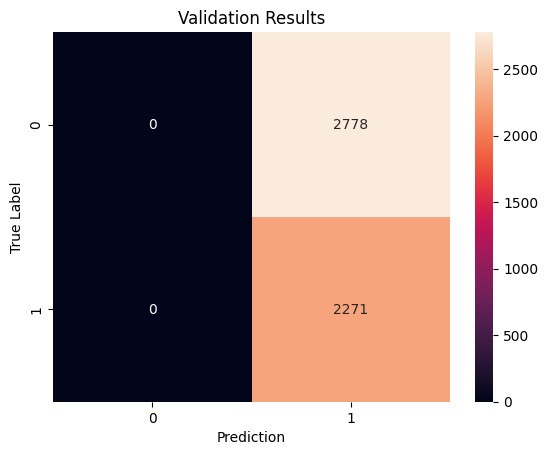

In [17]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_train.detach().numpy(), outputs.detach().numpy().round())
cm_train = pd.DataFrame(cm_train) #,index=['','>=$50K'],columns =['<$50K','>=$50K'])
sns.heatmap(cm_train,annot=True,fmt='g') #vmin=0,vmax=1,fmt=".1%"
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.title("Train Results")
plt.show()

### Validation Confusion Matrix

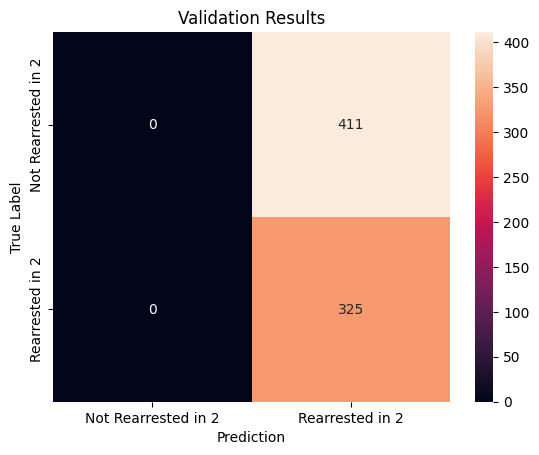

In [18]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_val = confusion_matrix(y_val.detach().numpy(), outputs_v.detach().numpy().round())
cm_val = pd.DataFrame(cm_val,index=['Not Rearrested in 2','Rearrested in 2'],columns =['Not Rearrested in 2','Rearrested in 2'])
sns.heatmap(cm_val,annot=True,fmt='g') #vmin=0,vmax=1,fmt=".1%"
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.title("Validation Results")
plt.show()